## 요약
- GridSearchCV를 이용하여 각 조건 별로 최적의 성능을 내는 hyperparameter를 탐색
- 기본 모델은 XGB
- 조건
  - 제외하는 col 없을 때
  - SalesPoint 제외
  - SalesPoint, RglrPrice 제외
    - 가격 예측
    - 할인율 예측

In [1]:
import os, natsort, re
from tqdm import tqdm
import time, random

In [2]:
from itertools import repeat, chain

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
#cd /content/drive/MyDrive/AI3_prjct2_aladin/

In [5]:
cd /content/drive/MyDrive/kdt-EST-AI/project/project2/

/content/drive/MyDrive/kdt-EST-AI/project/project2


In [6]:
# 로컬에서

#plt.rc("font", family = "D2Coding")
plt.rcParams["axes.unicode_minus"] = False

In [7]:
#PRJCT_PATH = '/home/doeun/code/AI/ESTSOFT2024/workspace/2.project_text/aladin_usedbook/'
PRJCT_PATH = '/content/drive/MyDrive/kdt-EST-AI/project/project2/'
#PRJCT_PATH = '/content/drive/MyDrive/AI3_prjct2_aladin/aladin_usedbook/'
save_dir = 'processed/model_input'
dir_path = os.path.join(PRJCT_PATH,save_dir)
#dir_path = './'

In [8]:
ls

 aladin_usedbook.gslides                  module_aladin/   research/
'aladin_usedbook 발표자료 초고.gslides'   processed/


In [9]:
!nvidia-smi

Mon Oct 21 01:58:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   41C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
import sys
sys.path.append(PRJCT_PATH)

In [11]:
import re
def erase_num_comma(text):
    pat = r'\d\,\d'
    idx_list = sorted([m.start()+1 for m in re.finditer(pat,text)])
    temp = list(text)
    for i in idx_list[::-1]:
        temp.pop(i)
    return ''.join(temp)

In [12]:
import pickle

def load_pkl(file_path):
    with open(file_path,'rb') as f:
        data = pickle.load(f)

    return data

- (0,5) : category
- (5,35) : BName
- (35,60) : BName_sub

In [13]:
## FUNCTIONS - DATA- SCORE REG RSLT

def mase_nontime(actual,pred,base_pred) -> np.ndarray:
    """
    MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    :param forecast: Forecast values. Shape: batch, time_o
    :param insample: Insample values. Shape: batch, time_i
    :param outsample: Target values. Shape: batch, time_o
    :param frequency: Frequency value
    :return: Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(actual - pred)) / np.mean(np.abs(actual - base_pred),)

def make_reg_score_dict(y_actual,y_pred,base_val):
    rmse_model, rmse_base = np.sqrt(mse(y_actual,y_pred)), np.sqrt(mse([base_val]*len(y_actual),y_actual))
    mape_model, mape_base = mape(y_actual,y_pred), mape([base_val]*len(y_actual),y_actual)
    mase_model, mase_base = mase_nontime(y_actual,y_pred,base_val),1
    r2_model, r2_base = r2_score(y_actual,y_pred), 0

    return {
        'rmse' : [rmse_model, rmse_base],
        'mape' : [mape_model, mape_base],
        'mase' : [mase_model, mase_base],
        'r2_score' : [r2_model,r2_base]
    }

def print_reg_score_dict(name,dict_score,cut_line=True):
    print('{}\nr2 score : {:.5f}'.format(name,dict_score['r2_score'][0]))
    print('rmse_model : {:.5f} / rmse_base : {:.5f}\t'.format(*dict_score['rmse']),
          'mape_model : {:.5f} / mape_base : {:.5f}\t'.format(*dict_score['mape']))
    if cut_line : print('-'*150)

def make_reg_score_entire(dict_data,dict_rslt,print_rslt=False):
    dict_score = dict()
    for col, val in dict_data.items():
        X = val['X']
        y_actual = val['y']
        y_pred = dict_rslt[col]
        dict_score[col] = make_reg_score_dict(y_actual,y_pred,np.mean(y_actual))
        if print_rslt : print_reg_score_dict(col,dict_score[col])
    return dict_score

In [14]:
def str_cutter(sentnc, ths = 16):
    words= sentnc.split(' ')
    rslt, pnt = [''], 0
    while pnt < len(words):
        last = '' if len(rslt)==0 else rslt[-1]
        next_ele = modify_strlen_ths(last,words[pnt],ths)
        rslt = rslt[:-1] + next_ele
        pnt += 1
    return '\n'.join(rslt)[1:]

def minimize_seq_idx_np(domain:np.array,func):
    vfunc = np.vectorize(func)
    temp = np.argsort(vfunc(domain))
    return temp[0]

def modify_strlen_ths(last,new,ths=16):
    front = len(last)
    space = ths - (1+front)
    if len(new) < space :
        rslt = [last + ' ' + new]
    else :
        if len(new) < ths:
            rslt = [last, new]
        else:
            cut = choose_split_point(len(new),space-1,ths-1)
            new_h, new_e = new[:cut]+'-', new[cut:]
            if cut < ths-1 :
                rslt = modify_strlen_ths(last+' '+new_h,new_e)
            else :
                rslt = [last] + modify_strlen_ths(new_h,new_e)
    return rslt

In [15]:
def plot_reg_score(dict_data,dict_rslt,dict_score):
    fig,axes = plt.subplots(len(dict_data),3,figsize=(15,4*len(dict_data)))
    for n, (col,data) in enumerate(dict_data.items()):
        ax_row = axes[n] if len(dict_data) > 1 else axes
        ax1, ax2, ax3 = ax_row[0], ax_row[1], ax_row[2]
        y_actual, y_pred = (data['y'], dict_rslt[col])
        train_y = dict_data['train']['y']
        base_pred = np.mean(train_y)

        sns.histplot(y_actual,label='actual',ax=ax1,alpha=0.5)
        sns.histplot(y_pred,label='pred',ax=ax1,alpha=0.5)
        ax1.legend(fontsize=9)

        sns.histplot(y_actual-base_pred,ax=ax2, label = 'baseline',alpha=0.5)
        sns.histplot(y_actual-y_pred,ax=ax2, label = 'pred',alpha=0.5)
        ax2.legend(fontsize=9)
        ax2.set_title('distribution of errors',fontsize=10)

        df_score = pd.DataFrame(dict_score[col]).T[[1,0]]
        xs = list(chain.from_iterable(repeat(val,2) for val in df_score.index))
        ax3r = ax3.twinx()
        sns.barplot(x=xs[:2],y=list(df_score.values.reshape(-1))[:2],
                    hue = ['pred','base']*1,ax=ax3,alpha=0.65,legend=False)
        sns.barplot(x=xs[2:],y=list(df_score.values.reshape(-1))[2:],
                    hue = ['pred','base']*3,ax=ax3r,alpha=0.8,legend=False)
        ax3r.set_ylim([0.0,1.15])
        ax3r.bar_label(ax3r.containers[0], fontsize=8, fmt='%.4f')
        ax3r.bar_label(ax3r.containers[1], fontsize=8, fmt='%.4f')
        ax3.grid(False)
        ax3r.grid(False)
        ax3r.set_yscale('linear')
        ax3.bar_label(ax3.containers[0], fontsize=8, fmt='%.4f')
        ax3.bar_label(ax3.containers[1], fontsize=8, fmt='%.4f')
        ax3.set_title('model score',fontsize=10)

        ax1.set_title(str_cutter(col+':distribution of data',50),fontsize=15,loc='left',ha='left')
        ax2.xaxis.set_label_coords(-0.02, -0.15)
        ax2.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>48}\n'.format(*dict_score[col]['rmse'],dict_score[col]['r2_score'][0],
            f'n = {len(y_actual)}'), fontsize=10,ha ='left')
        ax1.set_xlabel('')
        ax3.set_xlabel('')
        ax1.set_ylabel('count',fontsize =10)
        ax2.set_ylabel('count',fontsize =10)
        plt.setp(ax3.get_yticklabels(),rotation = 0, fontsize = 9, color='#333333')
        plt.setp(ax3r.get_yticklabels(),rotation = 0, fontsize = 9)

    for ax in axes.flatten():
        plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
        plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)

    return fig, axes

In [16]:
os.listdir(dir_path)

['whole.v1.0_st-False_X_test.pkl',
 'whole.v1.0_st-False_X_val.pkl',
 'whole.v1.0_st-False_y_val.pkl',
 'whole.v1.0_st-False_y_train.pkl',
 'whole.v1.0_st-False_y_test.pkl',
 'whole.v1.0_st-False_X_train.pkl',
 'whole.v1.0_st-False_y_discount_val.pkl',
 'whole.v1.0_st-False_y_discount_test.pkl',
 'whole.v1.0_st-False_y_discount_train.pkl',
 '241018_xgbgrid.pkl',
 '241019_xgbgrid_3.pkl',
 '241019_xgbgrid_2.pkl',
 '241019_xgbgrid_1.pkl',
 '241019_xgbgrid_4.pkl',
 '241020_xgbgrid_1.pkl',
 '241020_xgbgrid_2.pkl',
 '241020_xgbgrid_3.pkl',
 '241020_xgbgrid_4.pkl']

## 그리드서치

In [17]:
data_type = 'whole'
ver=1.0
strat= False
def load_data(data_type='whole',ver=1.0,strat=False,discount=False):
  dscnt = '' if not discount else '_discount'
  X_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_train.pkl'.format(data_type,ver,strat)))
  X_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_val.pkl'.format(data_type,ver,strat)))
  X_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_test.pkl'.format(data_type,ver,strat)))
  y_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y{}_train.pkl'.format(data_type,ver,strat,dscnt)))
  y_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y{}_val.pkl'.format(data_type,ver,strat,dscnt)))
  y_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y{}_test.pkl'.format(data_type,ver,strat,dscnt)))
  return X_train,X_val,X_test,y_train,y_val,y_test

X_train,X_val,X_test,y_train,y_val,y_test = load_data()

In [18]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 68)

(125474, 68)

(156843, 68)

(501896,)

(125474,)

(156843,)

In [19]:
h_params = {
    'n_estimators':[100,500,1000],
    'learning_rate':[0.5,0.3,0.1],
    'max_depth':[4,5,6],
    'min_child_weight' : [1,4,7],
#    'gamma' : [0,0.3,0.7],
#    'colsample_bytree':[0.5,1],
#    'subsample' : [0.4,0.7,1],
}

## XGB

**remove some col**
- -1 : SalesPoint
- -2 : RglrPrice

In [20]:
col_vector = ['Category','BName','BName_sub']
col_scalar=['quality',
 'store',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
# 'SlsPrice',
 'SalesPoint']

crop,crop_idx = True,[-1]
#crop,crop_idx = True,[-1,-2]

def polish_idx(length,crop_idx):
    crop_idx2 = list(map(lambda x : length + x if x < 0 else x, crop_idx))
    return sorted(crop_idx2,reverse=True)

def make_cropped_data(crop_idx, X):
    crop_idx = polish_idx(X.shape[1],crop_idx)
    for i in crop_idx:
        X = np.hstack([X[:,:i],X[:,i+1:]])
    return X

def crop_scalar_col(crop_idx, col_scalar):
    crop_idx = polish_idx(X_train.shape[1],crop_idx)
    for i in crop_idx:
        col_scalar =col_scalar[:i]+col_scalar[i+1:]
    return col_scalar

def cropped_col_setting(crop_idx,col_vector,col_scalar):
    col_scalar = crop_scalar_col(crop_idx,col_scalar)
    col_partition = [(0,5),(5,35),(35,60)]+[(60+i,61+i) for i in range(len(col_scalar))]
    return  list(zip(col_vector+col_scalar,col_partition))

def concat_fi_by_partition(fi_model,cols_setting):
    concatted_FI = dict()
    for (col,partition) in cols_setting:
        concatted_FI[col] = np.sum(fi_model[partition[0]:partition[1]])
    return concatted_FI

In [21]:
def load_cropped_data(crop_idx,**kwargs):
  X_train,X_val,X_test,y_train,y_val,y_test = load_data(**kwargs)
  X_train = make_cropped_data(crop_idx,X_train)
  X_val = make_cropped_data(crop_idx,X_val)
  X_test = make_cropped_data(crop_idx,X_test)
  return X_train,X_val,X_test,y_train,y_val,y_test

In [22]:
crop,crop_idx = False,[]#[-1,-2]
#crop,crop_idx = True,[-2]
#crop,crop_idx = True,[-1]
#crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : X_train.shape[1]+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        X_train = np.hstack([X_train[:,:i],X_train[:,i+1:]])
        X_val = np.hstack([X_val[:,:i],X_val[:,i+1:]])
        X_test = np.hstack([X_test[:,:i],X_test[:,i+1:]])

In [23]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 68)

(125474, 68)

(156843, 68)

(501896,)

(125474,)

(156843,)

In [24]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [25]:
import cupy

#https://github.com/dmlc/xgboost/issues/9791

cupy.cuda.Device(0).use()

<CUDA Device 0>

In [26]:
X_trn, y_trn = cupy.array(X_train),cupy.array(y_train)
X_vld, y_vld = cupy.array(X_val),cupy.array(y_val)

In [27]:
fit_params ={
    'tree_method' : 'hist',
    'device' : 'cuda:0',
    'early_stopping_rounds' : 'auto'
}

In [28]:
from copy import deepcopy
from itertools import product
from collections import defaultdict
from tqdm.auto import tqdm
from xgboost import XGBRegressor
import xgboost as xgb
from functools import reduce
from sklearn.metrics import mean_absolute_error, make_scorer

def calc_prod(vals):
  return reduce(lambda x,y:x*y,vals, 1)

In [29]:
def GridSearchCV_XGB_cupy(param_grid, fit_params, scorer, cv, X, y):
    """This function performs grid search for the best set of parameters of XGBoost model with early stopping.

    Args:
        param_grid (dict): The parameter ranges for which the function searches.
        fit_params (dict): The fitting parameters for XGBoost.
        scorer (_PredictScorer): The sklearn's scorer instance.
        cv (model_selection._split): The sklearn's split instance.
        X (cupy array): The input data matrix.
        y (cupy array): The ground truth label.

    Returns:
        dict: The best set of parameters found via grid search.
    """
    param_names, param_values = zip(*list(param_grid.items()))

    cv_best_iterations = defaultdict(list)
    cv_results = defaultdict(list)

    for train_index, test_index in cv.split(X, y):
        X_in, X_out = X[train_index], X[test_index]
        y_in, y_out = y[train_index], y[test_index]

        fit_params_cv = deepcopy(fit_params)

        for value_combination in tqdm(product(*param_values),total=calc_prod(map(len,param_values))):
            param_grid_key = tuple(zip(param_names, value_combination))
            param_grid_cv = dict(param_grid_key)

            if 'early_stopping_rounds' in fit_params_cv and fit_params_cv['early_stopping_rounds'] == 'auto':
              fit_params_cv['early_stopping_rounds'] = int(np.log10(param_grid_cv['n_estimators'])*15)
            xgboost = XGBRegressor(**param_grid_cv,**fit_params_cv)

            xgboost.fit(X_in, y_in,eval_set=[(X_in, y_in), (X_out, y_out)],verbose=False)
            best_iteration = xgboost.get_num_boosting_rounds() if 'early_stopping_rounds' not in fit_params_cv else xgboost.best_iteration
            cv_best_iterations[param_grid_key].append(best_iteration)

            score = scorer(xgboost, X_out.get(), y_out.get())
            cv_results[param_grid_key].append(score)

    best_params_xgb, score_list = max(cv_results.items(), key=lambda x: np.array(x[1]).mean())

    # Note that our XGBoost model may stop early,
    # so we calculate the mean of the actual number of estimators in each fold,
    # in place of the originally planned n_estimators after finishing cross validation.
    n_estimators = int(round(np.array(cv_best_iterations[best_params_xgb]).mean()))

    best_params_xgb = dict(best_params_xgb)
    best_params_xgb['n_estimators'] = n_estimators

    print ("Best score: {:.3f}".format(np.array(score_list).mean()))
    print ("Best Parameters: {}".format(best_params_xgb))

    return best_params_xgb

#https://www.kaggle.com/code/yantiz/xgboost-gridsearchcv-with-early-stopping-supported

In [ ]:
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import KFold
kf = KFold(n_splits=2, shuffle=True)
scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
best_params = GridSearchCV_XGB_cupy(h_params,fit_params,scorer,kf, X_trn,y_trn)

  0%|          | 0/81 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:17:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [30]:
from copy import deepcopy
from itertools import product
from collections import defaultdict
from tqdm.auto import tqdm
from xgboost import XGBRegressor
import xgboost as xgb
import numpy as np
from functools import reduce
from sklearn.metrics import mean_absolute_error, r2_score

def get_early_stop_round(fit_params,n_rounds):
    if 'early_stopping_rounds' in fit_params:
      if fit_params['early_stopping_rounds'] == 'auto': return int(np.log10(n_rounds)*15)
      else : return fit_params['early_stopping_rounds']
    else : return None

def del_dict_keys(data,arr):
  rslt = deepcopy(data)
  for ele in arr:
    if ele in rslt : del rslt[ele]
  return rslt

def train_XGB_DM(params, d_trn, d_vld,metric):
    n_rounds = params['num_boost_round'] if 'num_boost_round' in params else 100
    n_earlystop = get_early_stop_round(params,n_rounds)
    early_stop = xgb.callback.EarlyStopping(
        rounds=n_earlystop,
        metric_name=metric,
        data_name="vld",
        save_best=True,)

    hyper_param = del_dict_keys(params,['num_boost_round','early_stopping_rounds'])
    xgb_model = xgb.train(hyper_param,d_trn,
                        evals=[(d_trn,'train'),(d_vld,'vld')],
                        num_boost_round=n_rounds,
                        early_stopping_rounds=n_earlystop,
                        callbacks=[early_stop],verbose_eval=False)
    return xgb_model

def concat_dict(dict_list):
    rslt = defaultdict(list)
    for dic in dict_list:
      for key, val in dic.items():
        rslt[key].append(val)
    return {key : np.array(val) for key,val in rslt.items()}

def combine_dict(dict1,dict2):
  key_all = set(dict1.keys()).union(dict2.keys())
  rslt = dict()
  for key in key_all :
    if key in dict1 : rslt[key] = dict1[key]
    else : rslt[key] = dict2[key]
  return rslt

def process_score_str(score_str):
  scores,rslt = score_str.split('	'), dict()
  for sentn in scores[1:]:
    temp = sentn.split(':')
    rslt[temp[0].split('-')[-1]] = float(temp[-1])
  return rslt

def get_ranks(val_arr:np.array,):
  order = np.argsort(val_arr)
  return np.argsort(order)

'''
arry : [a_0,a_1,...,a_n]
ordr : [b_0,b_1,...,b_n]
rank : [c_0,c_1,...,c_n]

ordr = argsort(arry)
WTS rank = argsort(ordr)

since rank is ranking, c_bx = x
(i.e. # of values smaller than a_bx = x)
argsort means a_bx is x-th smallest number in a
let d_x is argsort(b_x), then b_dx is x-th smallest number in b, and it is x.
since, b_dx = c_bx = x and b,c are permutations, thus d = b^-1 = c
'''

def r2_DM(predt: np.ndarray, dtrain: xgb.DMatrix):
    '''r2 score'''
    return 'r2_score', r2_score(predt,dtrain.get_label())

def drop_dict_level(data,key_name='key'):
  keys, val_dicts = zip(*list(data.items()))
  rslt = concat_dict(val_dicts)
  rslt[key_name] = np.array(keys)
  return rslt


In [31]:
def GridSearchCV_XGB_DM(param_grid, fit_params, metric, cv, X, y):
    """This function performs grid search for the best set of parameters of XGBoost model with early stopping.

    Args:
        param_grid (dict): The parameter ranges for which the function searches.
        fit_params (dict): The fitting parameters for XGBoost.
        scorer (_PredictScorer): The sklearn's scorer instance.
        cv (model_selection._split): The sklearn's split instance.
        X (cupy array): The input data matrix.
        y (cupy array): The ground truth label.

    Returns:
        dict: The best set of parameters found via grid search.
    """
    param_names, param_values = zip(*list(param_grid.items()))

    cv_rounds = defaultdict(lambda : np.array([]))
#    cv_rounds = defaultdict(list)
    cv_scores = defaultdict(list)

    for train_idx, test_idx in cv.split(X, y):

        d_trn = xgb.DMatrix(X[train_idx],label=y[train_idx])
        d_vld = xgb.DMatrix(X[test_idx],label=y[test_idx])
        fit_params_cv = deepcopy(fit_params)

        for value_combination in tqdm(product(*param_values),total=calc_prod(map(len,param_values))):
            param_grid_key = tuple(zip(param_names, value_combination))
            param_grid_cv = dict(param_grid_key)

            params = combine_dict(param_grid_cv,fit_params_cv)
            xgb_model = train_XGB_DM(params,d_trn,d_vld,metric)
            best_iteration = xgb_model.get_num_boosting_rounds() if 'early_stopping_rounds' not in fit_params_cv else xgb_model.best_iteration
#            cv_rounds[param_grid_key].append(best_iteration)
            cv_rounds[param_grid_key]=np.append(cv_rounds[param_grid_key],best_iteration)
            score_str = xgb_model.eval_set(evals=[(d_vld,'vld')],feval=r2_DM)
            score = process_score_str(score_str)
            cv_scores[param_grid_key].append(score)

    rslt_dict = {
        param : {'score' : concat_dict(scores)}
        for param, scores in cv_scores.items()
    }
    for param,n_round in cv_rounds.items():
      rslt_dict[param]['actual_rounds'] = n_round
      rslt_dict[param]['mean_rounds'] = int(np.ceil(np.mean(n_round)))
      rslt_dict[param]['mean_score'] = np.mean(rslt_dict[param]['score']['r2_score'])

    rslt = drop_dict_level(rslt_dict,'params')
    rslt['rank_score'] = get_ranks(-rslt['mean_score'])

    best_idx = rslt['rank_score']==0
    best_params_xgb,best_rslt = rslt['params'][best_idx][0],rslt['mean_score'][best_idx][0]
    best_params_xgb = dict(best_params_xgb)

    print ("Best score: {:.5f}".format(best_rslt))
    print ("Best Parameters: {}".format(best_params_xgb))

    return best_params_xgb, rslt

#https://www.kaggle.com/code/yantiz/xgboost-gridsearchcv-with-early-stopping-supported

In [32]:
h_params_DM = {
    'num_boost_round':[100,1500,2500],
    'learning_rate':[0.5,0.3,0.1],
    'max_depth':[4,5,6],
    'min_child_weight' : [1,4,7],
#    'alpha' : [0,1,5],
    'colsample_bytree':[0.5,1],
    'subsample' : [0.4,0.7,1],
}

In [33]:
def save_pkl(save_dir,file_name,save_object):
    if not os.path.exists(save_dir): os.mkdir(save_dir)
    file_path = os.path.join(save_dir,file_name)
    with open(file_path,'wb') as f:
        pickle.dump(save_object,f)

## Expt. 1 : no crop

In [34]:
X_train,X_val,X_test,y_train,y_val,y_test = load_cropped_data([])
X_trn, y_trn = cupy.array(X_train),cupy.array(y_train)
X_vld, y_vld = cupy.array(X_val),cupy.array(y_val)

In [35]:
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True)
best_params,rslt1 = GridSearchCV_XGB_DM(h_params_DM,fit_params,'rmse',kf, X_trn,y_trn)

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

Best score: 0.97207
Best Parameters: {'num_boost_round': '2500', 'learning_rate': '0.3', 'max_depth': '6', 'min_child_weight': '1', 'colsample_bytree': '0.5', 'subsample': '1'}


In [36]:
save_pkl(dir_path,'241020_xgbgrid_01.pkl',rslt1)

In [37]:
rslt1 = load_pkl(os.path.join(dir_path,'241020_xgbgrid_01.pkl'))

In [48]:
display('top 10 : ',rslt1['mean_score'][rslt1['rank_score']<10])
display('top 7 : ',rslt1['params'][rslt1['rank_score']<7])

'top 10 : '

array([0.97080767, 0.97098567, 0.97100033, 0.97077167, 0.972066  ,
       0.97171833, 0.97140833, 0.97163233, 0.97144567, 0.971428  ])

'top 7 : '

array([[['num_boost_round', '1500'],
        ['learning_rate', '0.3'],
        ['max_depth', '6'],
        ['min_child_weight', '4'],
        ['colsample_bytree', '1'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.3'],
        ['max_depth', '6'],
        ['min_child_weight', '1'],
        ['colsample_bytree', '0.5'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.3'],
        ['max_depth', '6'],
        ['min_child_weight', '1'],
        ['colsample_bytree', '1'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.3'],
        ['max_depth', '6'],
        ['min_child_weight', '4'],
        ['colsample_bytree', '0.5'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.3'],
        ['max_depth', '6'],
        ['min_child_weight', '4'],
        ['colsample_bytree', '1'],
        ['subsample', '1']],

 

In [50]:
display('top 7 : ',rslt1['mean_score'][rslt1['rank_score']<7])
display('top 7 : ',rslt1['rank_score'][rslt1['rank_score']<7])

'top 7 : '

array([0.97100033, 0.972066  , 0.97171833, 0.97140833, 0.97163233,
       0.97144567, 0.971428  ])

'top 7 : '

array([6, 0, 1, 5, 2, 3, 4])

In [55]:
list(map(dict,rslt1['params'][rslt1['rank_score']<7]))

[{'num_boost_round': '1500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '4',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '1',
  'colsample_bytree': '0.5',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '1',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '4',
  'colsample_bytree': '0.5',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '4',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '7',
  'colsample_bytree': '0.5',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight

In [39]:
display('n_rounds 100 : ',np.sort(rslt1['rank_score'][rslt1['params'][:,0,1]=='100'])[:20])
target = (rslt1['rank_score'][rslt1['params'][:,0,1]=='100'])[:20]
display(rslt1['mean_score'][np.isin(rslt1['rank_score'],target)])
print('-'*50)
display('n_rounds 500 : ',np.sort(rslt1['rank_score'][rslt1['params'][:,0,1]=='500'])[:20])
target = (rslt1['rank_score'][rslt1['params'][:,0,1]=='500'])[:20]
display(rslt1['mean_score'][np.isin(rslt1['rank_score'],target)])
print('-'*50)
display('depth 4: ',np.sort(rslt1['rank_score'][rslt1['params'][:,2,1]=='4'])[:20])
target = (rslt1['rank_score'][rslt1['params'][:,2,1]=='4'])[:20]
display(rslt1['mean_score'][np.isin(rslt1['rank_score'],target)])
print('-'*50)
display('depth 5: ',np.sort(rslt1['rank_score'][rslt1['params'][:,2,1]=='5'])[:20])
target = (rslt1['rank_score'][rslt1['params'][:,2,1]=='5'])[:20]
display(rslt1['mean_score'][np.isin(rslt1['rank_score'],target)])

'n_rounds 100 : '

array([249, 260, 263, 281, 282, 285, 288, 289, 294, 296, 302, 303, 305,
       306, 310, 313, 322, 323, 325, 326])

array([0.948813  , 0.94963767, 0.95219133, 0.95193367, 0.95401567,
       0.95523933, 0.948919  , 0.94998233, 0.95145667, 0.95206167,
       0.95295533, 0.95450133, 0.948344  , 0.95058033, 0.95133833,
       0.95098633, 0.95255967, 0.95428933, 0.950492  , 0.95281567])

--------------------------------------------------


'n_rounds 500 : '

array([], dtype=int64)

array([], dtype=float64)

--------------------------------------------------


'depth 4: '

array([ 60,  68,  75,  84,  86,  88,  91,  95, 103, 105, 106, 122, 127,
       129, 130, 131, 141, 145, 150, 151])

array([0.948813  , 0.94963767, 0.95219133, 0.95193367, 0.95401567,
       0.95523933, 0.948919  , 0.94998233, 0.95145667, 0.95206167,
       0.95295533, 0.95450133, 0.948344  , 0.95058033, 0.95133833,
       0.95098633, 0.95255967, 0.95428933, 0.949919  , 0.95097133])

--------------------------------------------------


'depth 5: '

array([15, 16, 17, 19, 20, 25, 27, 28, 33, 39, 41, 42, 44, 47, 48, 51, 54,
       55, 56, 63])

array([0.950492  , 0.95281567, 0.95541467, 0.95451233, 0.95659533,
       0.957509  , 0.94979367, 0.953283  , 0.95403967, 0.95198667,
       0.95568633, 0.957575  , 0.95015233, 0.95247467, 0.95417567,
       0.95343567, 0.955458  , 0.95694167, 0.951759  , 0.95290767])

## Expt. 2 : crop -1

In [229]:
X_train,X_val,X_test,y_train,y_val,y_test = load_cropped_data([-1])
X_trn, y_trn = cupy.array(X_train),cupy.array(y_train)
X_vld, y_vld = cupy.array(X_val),cupy.array(y_val)

In [230]:
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True)
best_params2,rslt2 = GridSearchCV_XGB_DM(h_params_DM,fit_params,'rmse',kf, X_trn,y_trn)

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

Best score: 0.97139
Best Parameters: {'num_boost_round': '2500', 'learning_rate': '0.3', 'max_depth': '6', 'min_child_weight': '1', 'colsample_bytree': '0.5', 'subsample': '1'}


In [231]:
save_pkl(dir_path,'241020_xgbgrid_2.pkl',rslt2)

In [42]:
rslt2 = load_pkl(os.path.join(dir_path,'241020_xgbgrid_2.pkl'))

In [43]:
display('top 10 : ',rslt2['mean_score'][rslt2['rank_score']<10])
display('top 7 : ',rslt2['params'][rslt2['rank_score']<7])

'top 10 : '

array([0.970097  , 0.970358  , 0.97003667, 0.97138633, 0.96999   ,
       0.971102  , 0.970576  , 0.97029233, 0.970368  , 0.970486  ])

'top 7 : '

array([[['num_boost_round', '2500'],
        ['learning_rate', '0.5'],
        ['max_depth', '5'],
        ['min_child_weight', '1'],
        ['colsample_bytree', '1'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.3'],
        ['max_depth', '6'],
        ['min_child_weight', '1'],
        ['colsample_bytree', '0.5'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.3'],
        ['max_depth', '6'],
        ['min_child_weight', '1'],
        ['colsample_bytree', '1'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.3'],
        ['max_depth', '6'],
        ['min_child_weight', '4'],
        ['colsample_bytree', '0.5'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.3'],
        ['max_depth', '6'],
        ['min_child_weight', '4'],
        ['colsample_bytree', '1'],
        ['subsample', '1']],

 

In [51]:
display('top 7 : ',rslt2['mean_score'][rslt2['rank_score']<7])
display('top 7 : ',rslt2['rank_score'][rslt2['rank_score']<7])

'top 7 : '

array([0.970358  , 0.97138633, 0.971102  , 0.970576  , 0.97029233,
       0.970368  , 0.970486  ])

'top 7 : '

array([5, 0, 1, 2, 6, 4, 3])

In [56]:
list(map(dict,rslt2['params'][rslt2['rank_score']<7]))

[{'num_boost_round': '2500',
  'learning_rate': '0.5',
  'max_depth': '5',
  'min_child_weight': '1',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '1',
  'colsample_bytree': '0.5',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '1',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '4',
  'colsample_bytree': '0.5',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '4',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '7',
  'colsample_bytree': '0.5',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight

In [234]:
display('n_rounds 100 : ',np.sort(rslt2['rank_score'][rslt2['params'][:,0,1]=='100'])[:20])
target = (rslt2['rank_score'][rslt2['params'][:,0,1]=='100'])[:20]
display(rslt2['mean_score'][np.isin(rslt2['rank_score'],target)])
print('-'*50)
display('n_rounds 500 : ',np.sort(rslt2['rank_score'][rslt2['params'][:,0,1]=='500'])[:20])
target = (rslt2['rank_score'][rslt2['params'][:,0,1]=='500'])[:20]
display(rslt2['mean_score'][np.isin(rslt2['rank_score'],target)])
print('-'*50)
display('depth 4: ',np.sort(rslt2['rank_score'][rslt2['params'][:,2,1]=='4'])[:20])
target = (rslt2['rank_score'][rslt2['params'][:,2,1]=='4'])[:20]
display(rslt2['mean_score'][np.isin(rslt2['rank_score'],target)])
print('-'*50)
display('depth 5: ',np.sort(rslt2['rank_score'][rslt2['params'][:,2,1]=='5'])[:20])
target = (rslt2['rank_score'][rslt2['params'][:,2,1]=='5'])[:20]
display(rslt2['mean_score'][np.isin(rslt2['rank_score'],target)])

'n_rounds 100 : '

array([253, 269, 270, 282, 289, 291, 294, 298, 301, 305, 306, 307, 308,
       309, 310, 311, 313, 317, 318, 319])

array([0.94872333, 0.95001533, 0.95086733, 0.95207733, 0.95367067,
       0.95388933, 0.94842967, 0.94945467, 0.950033  , 0.951063  ,
       0.95297467, 0.95327967, 0.94738667, 0.94958233, 0.950612  ,
       0.950701  , 0.95218967, 0.95336767, 0.95077667, 0.95291267])

--------------------------------------------------


'n_rounds 500 : '

array([], dtype=int64)

array([], dtype=float64)

--------------------------------------------------


'depth 4: '

array([ 63,  68,  73,  74,  82,  96, 100, 103, 107, 112, 113, 117, 124,
       125, 131, 134, 138, 144, 146, 150])

array([0.94872333, 0.95001533, 0.95086733, 0.95207733, 0.95367067,
       0.95388933, 0.94842967, 0.94945467, 0.950033  , 0.951063  ,
       0.95297467, 0.95327967, 0.94738667, 0.94958233, 0.950612  ,
       0.950701  , 0.95218967, 0.95336767, 0.948996  , 0.95002633])

--------------------------------------------------


'depth 5: '

array([ 5, 10, 15, 19, 24, 25, 27, 28, 30, 31, 34, 40, 41, 44, 49, 50, 51,
       60, 61, 62])

array([0.95077667, 0.95291267, 0.95416067, 0.95375733, 0.95581433,
       0.95676967, 0.94819167, 0.95060267, 0.95277867, 0.95208867,
       0.95404233, 0.95546233, 0.948917  , 0.95136767, 0.95319467,
       0.95177933, 0.95308767, 0.95538767, 0.95034167, 0.95232133])

## Expt. 3 : crop -1, -2

In [235]:
X_train,X_val,X_test,y_train,y_val,y_test = load_cropped_data([-1, -2])
X_trn, y_trn = cupy.array(X_train),cupy.array(y_train)
X_vld, y_vld = cupy.array(X_val),cupy.array(y_val)

In [236]:
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True)
best_params3,rslt3 = GridSearchCV_XGB_DM(h_params_DM,fit_params,'rmse',kf, X_trn,y_trn)

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

Best score: 0.89926
Best Parameters: {'num_boost_round': '2500', 'learning_rate': '0.5', 'max_depth': '6', 'min_child_weight': '1', 'colsample_bytree': '1', 'subsample': '1'}


In [237]:
save_pkl(dir_path,'241020_xgbgrid_3.pkl',rslt3)

In [44]:
rslt3 = load_pkl(os.path.join(dir_path,'241020_xgbgrid_3.pkl'))

In [47]:
display('top 10 : ',rslt3['mean_score'][rslt3['rank_score']<10])
display('top 7 : ',rslt3['params'][rslt3['rank_score']<7])

'top 10 : '

array([0.89100367, 0.887827  , 0.89925833, 0.88990833, 0.88651   ,
       0.89525467, 0.89448833, 0.89034133, 0.88805   , 0.88664233])

'top 7 : '

array([[['num_boost_round', '2500'],
        ['learning_rate', '0.5'],
        ['max_depth', '6'],
        ['min_child_weight', '1'],
        ['colsample_bytree', '0.5'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.5'],
        ['max_depth', '6'],
        ['min_child_weight', '1'],
        ['colsample_bytree', '1'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.5'],
        ['max_depth', '6'],
        ['min_child_weight', '4'],
        ['colsample_bytree', '0.5'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.5'],
        ['max_depth', '6'],
        ['min_child_weight', '4'],
        ['colsample_bytree', '1'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.5'],
        ['max_depth', '6'],
        ['min_child_weight', '7'],
        ['colsample_bytree', '1'],
        ['subsample', '1']],

 

In [52]:
display('top 7 : ',rslt3['mean_score'][rslt3['rank_score']<7])
display('top 7 : ',rslt3['rank_score'][rslt3['rank_score']<7])

'top 7 : '

array([0.89100367, 0.89925833, 0.88990833, 0.89525467, 0.89448833,
       0.89034133, 0.88805   ])

'top 7 : '

array([3, 0, 5, 1, 2, 4, 6])

In [57]:
list(map(dict,rslt3['params'][rslt3['rank_score']<7]))

[{'num_boost_round': '2500',
  'learning_rate': '0.5',
  'max_depth': '6',
  'min_child_weight': '1',
  'colsample_bytree': '0.5',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.5',
  'max_depth': '6',
  'min_child_weight': '1',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.5',
  'max_depth': '6',
  'min_child_weight': '4',
  'colsample_bytree': '0.5',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.5',
  'max_depth': '6',
  'min_child_weight': '4',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.5',
  'max_depth': '6',
  'min_child_weight': '7',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '1',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight':

In [240]:
display('n_rounds 100 : ',np.sort(rslt3['rank_score'][rslt3['params'][:,0,1]=='100'])[:20])
target = (rslt3['rank_score'][rslt3['params'][:,0,1]=='100'])[:20]
display(rslt3['mean_score'][np.isin(rslt3['rank_score'],target)])
print('-'*50)
display('n_rounds 500 : ',np.sort(rslt3['rank_score'][rslt3['params'][:,0,1]=='500'])[:20])
target = (rslt3['rank_score'][rslt3['params'][:,0,1]=='500'])[:20]
display(rslt3['mean_score'][np.isin(rslt3['rank_score'],target)])
print('-'*50)
display('depth 4: ',np.sort(rslt3['rank_score'][rslt3['params'][:,2,1]=='4'])[:20])
target = (rslt3['rank_score'][rslt3['params'][:,2,1]=='4'])[:20]
display(rslt3['mean_score'][np.isin(rslt3['rank_score'],target)])
print('-'*50)
display('depth 5: ',np.sort(rslt3['rank_score'][rslt3['params'][:,2,1]=='5'])[:20])
target = (rslt3['rank_score'][rslt3['params'][:,2,1]=='5'])[:20]
display(rslt3['mean_score'][np.isin(rslt3['rank_score'],target)])

'n_rounds 100 : '

array([294, 297, 299, 303, 305, 310, 311, 312, 314, 315, 316, 317, 319,
       324, 328, 329, 332, 335, 337, 339])

array([0.32525033, 0.34716133, 0.36168933, 0.362167  , 0.38674133,
       0.39672267, 0.32196733, 0.34972967, 0.368986  , 0.346015  ,
       0.37806033, 0.38545933, 0.32185567, 0.35432567, 0.36453267,
       0.33502967, 0.369383  , 0.38642567, 0.44924633, 0.49115633])

--------------------------------------------------


'n_rounds 500 : '

array([], dtype=int64)

array([], dtype=float64)

--------------------------------------------------


'depth 4: '

array([141, 145, 146, 149, 154, 160, 162, 163, 167, 173, 179, 180, 181,
       182, 184, 186, 188, 190, 192, 194])

array([0.32525033, 0.34716133, 0.36168933, 0.362167  , 0.38674133,
       0.39672267, 0.32196733, 0.34972967, 0.368986  , 0.346015  ,
       0.37806033, 0.38545933, 0.32185567, 0.35432567, 0.36453267,
       0.33502967, 0.369383  , 0.38642567, 0.24756833, 0.27671233])

--------------------------------------------------


'depth 5: '

array([29, 34, 36, 47, 48, 51, 54, 57, 60, 63, 65, 67, 73, 74, 75, 76, 79,
       81, 82, 83])

array([0.44924633, 0.49115633, 0.49038367, 0.48060533, 0.51874667,
       0.52012933, 0.434828  , 0.47249167, 0.489995  , 0.45617567,
       0.502686  , 0.51844933, 0.420383  , 0.46244833, 0.48814   ,
       0.44845567, 0.49831733, 0.508835  , 0.37097433, 0.38471067])

## Expt. 4-1 : predict discount ratio (crop -1,-2)

In [241]:
X_train,X_val,X_test,y_train,y_val,y_test = load_cropped_data([-1, -2],discount=True)
X_trn, y_trn = cupy.array(X_train),cupy.array(y_train)
X_vld, y_vld = cupy.array(X_val),cupy.array(y_val)

In [242]:
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True)
best_params4,rslt4 = GridSearchCV_XGB_DM(h_params_DM,fit_params,'rmse',kf, X_trn,y_trn)

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

Best score: 0.79887
Best Parameters: {'num_boost_round': '2500', 'learning_rate': '0.3', 'max_depth': '6', 'min_child_weight': '4', 'colsample_bytree': '1', 'subsample': '1'}


In [243]:
save_pkl(dir_path,'241020_xgbgrid_4.pkl',rslt4)

In [45]:
rslt4 = load_pkl(os.path.join(dir_path,'241020_xgbgrid_4.pkl'))

In [46]:
display('top 10 : ',rslt4['mean_score'][rslt4['rank_score']<10])
display('top 7 : ',rslt4['params'][rslt4['rank_score']<7])

'top 10 : '

array([0.798142  , 0.795941  , 0.79784833, 0.79503733, 0.797917  ,
       0.79572   , 0.798722  , 0.79488667, 0.798866  , 0.79822633])

'top 7 : '

array([[['num_boost_round', '2500'],
        ['learning_rate', '0.5'],
        ['max_depth', '6'],
        ['min_child_weight', '1'],
        ['colsample_bytree', '0.5'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.5'],
        ['max_depth', '6'],
        ['min_child_weight', '1'],
        ['colsample_bytree', '1'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.5'],
        ['max_depth', '6'],
        ['min_child_weight', '4'],
        ['colsample_bytree', '0.5'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.5'],
        ['max_depth', '6'],
        ['min_child_weight', '7'],
        ['colsample_bytree', '0.5'],
        ['subsample', '1']],

       [['num_boost_round', '2500'],
        ['learning_rate', '0.3'],
        ['max_depth', '6'],
        ['min_child_weight', '1'],
        ['colsample_bytree', '1'],
        ['subsample', '1']],


In [54]:
display('top 7 : ',rslt4['mean_score'][rslt4['rank_score']<7])
display('top 7 : ',rslt4['rank_score'][rslt4['rank_score']<7])

'top 7 : '

array([0.798142  , 0.795941  , 0.79784833, 0.797917  , 0.798722  ,
       0.798866  , 0.79822633])

'top 7 : '

array([3, 6, 5, 4, 1, 0, 2])

In [58]:
list(map(dict,rslt4['params'][rslt4['rank_score']<7]))

[{'num_boost_round': '2500',
  'learning_rate': '0.5',
  'max_depth': '6',
  'min_child_weight': '1',
  'colsample_bytree': '0.5',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.5',
  'max_depth': '6',
  'min_child_weight': '1',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.5',
  'max_depth': '6',
  'min_child_weight': '4',
  'colsample_bytree': '0.5',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.5',
  'max_depth': '6',
  'min_child_weight': '7',
  'colsample_bytree': '0.5',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '1',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight': '4',
  'colsample_bytree': '1',
  'subsample': '1'},
 {'num_boost_round': '2500',
  'learning_rate': '0.3',
  'max_depth': '6',
  'min_child_weight

In [245]:
display('n_rounds 100 : ',np.sort(rslt4['rank_score'][rslt4['params'][:,0,1]=='100'])[:20])
target = (rslt4['rank_score'][rslt4['params'][:,0,1]=='100'])[:20]
display(rslt4['mean_score'][np.isin(rslt4['rank_score'],target)])
print('-'*50)
display('n_rounds 500 : ',np.sort(rslt4['rank_score'][rslt4['params'][:,0,1]=='500'])[:20])
target = (rslt4['rank_score'][rslt4['params'][:,0,1]=='500'])[:20]
display(rslt4['mean_score'][np.isin(rslt4['rank_score'],target)])
print('-'*50)
display('depth 4: ',np.sort(rslt4['rank_score'][rslt4['params'][:,2,1]=='4'])[:20])
target = (rslt4['rank_score'][rslt4['params'][:,2,1]=='4'])[:20]
display(rslt4['mean_score'][np.isin(rslt4['rank_score'],target)])
print('-'*50)
display('depth 5: ',np.sort(rslt4['rank_score'][rslt4['params'][:,2,1]=='5'])[:20])
target = (rslt4['rank_score'][rslt4['params'][:,2,1]=='5'])[:20]
display(rslt4['mean_score'][np.isin(rslt4['rank_score'],target)])

'n_rounds 100 : '

array([303, 304, 305, 307, 310, 311, 312, 313, 315, 318, 319, 320, 321,
       324, 326, 337, 340, 341, 342, 343])

array([0.61321533, 0.617559  , 0.61988933, 0.62074533, 0.623142  ,
       0.62529367, 0.614442  , 0.61859567, 0.618038  , 0.61991667,
       0.62506267, 0.624968  , 0.61482167, 0.61700133, 0.61755167,
       0.620473  , 0.62385867, 0.62574   , 0.63480967, 0.63828933])

--------------------------------------------------


'n_rounds 500 : '

array([], dtype=int64)

array([], dtype=float64)

--------------------------------------------------


'depth 4: '

array([111, 112, 113, 131, 132, 134, 149, 150, 153, 163, 165, 166, 167,
       168, 169, 179, 180, 181, 192, 193])

array([0.61321533, 0.617559  , 0.61988933, 0.62074533, 0.623142  ,
       0.62529367, 0.614442  , 0.61859567, 0.618038  , 0.61991667,
       0.62506267, 0.624968  , 0.61482167, 0.61700133, 0.61755167,
       0.620473  , 0.62385867, 0.62574   , 0.60161533, 0.60322267])

--------------------------------------------------


'depth 5: '

array([24, 25, 29, 33, 34, 35, 50, 52, 53, 55, 56, 57, 59, 60, 63, 67, 68,
       69, 72, 73])

array([0.63480967, 0.63828933, 0.63825067, 0.63887833, 0.64722133,
       0.64865033, 0.632465  , 0.63878   , 0.64039533, 0.64151   ,
       0.64646867, 0.64862933, 0.63325167, 0.637769  , 0.63811667,
       0.64026833, 0.64575833, 0.648633  , 0.62125667, 0.6225    ])

# Analysis

In [ ]:
rslt1 = load_pkl(os.path.join(dir_path,'241019_xgbgrid_1.pkl'))
rslt2 = load_pkl(os.path.join(dir_path,'241019_xgbgrid_2.pkl'))
rslt3 = load_pkl(os.path.join(dir_path,'241019_xgbgrid_3.pkl'))
rslt4 = load_pkl(os.path.join(dir_path,'241019_xgbgrid_4.pkl'))

In [ ]:
rslt1.keys()

dict_keys(['score', 'actual_rounds', 'mean_rounds', 'mean_score', 'params', 'rank_score'])

In [ ]:
import pandas as pd
temp = {
    key : list(val)
    for key,val in rslt1.items()
}
df = pd.DataFrame(temp)

df['std_rounds'] = df.actual_rounds.apply(np.std)
pd.Series(dict(df.loc[0,'params']))

,0
num_boost_round,100
learning_rate,0.5
max_depth,4
min_child_weight,1
gamma,0
colsample_bytree,0.5
subsample,0.4


In [ ]:
df.columns

Index(['score', 'actual_rounds', 'mean_rounds', 'mean_score', 'params',
       'rank_score', 'std_rounds'],
      dtype='object')

In [ ]:
df.loc[0,'score']

{'rmse': array([820.64688827, 824.40667397, 832.51923626]),
 'r2_score': array([0.949578, 0.950386, 0.949441])}

In [ ]:
df_param = pd.DataFrame(list(df['params'].apply(dict).values))
df_score = pd.DataFrame(list(df['score'].apply(dict).values))
df_rmse=pd.DataFrame(df_score['rmse'].values.tolist()).add_prefix('rmse')
df_r2 = pd.DataFrame(df_score['r2_score'].values.tolist()).add_prefix('r2_score')
data = pd.concat([df_param,df_rmse,df_r2,df[[ 'actual_rounds', 'mean_rounds', 'mean_score',
       'rank_score']]],axis=1)
data

,num_boost_round,learning_rate,max_depth,min_child_weight,gamma,colsample_bytree,subsample,rmse0,rmse1,rmse2,r2_score0,r2_score1,r2_score2,actual_rounds,mean_rounds,mean_score,rank_score
0,100,0.5,4,1,0,0.5,0.4,820.646888,824.406674,832.519236,0.949578,0.950386,0.949441,"[99.0, 94.0, 94.0]",96,0.949802,1356
1,100,0.5,4,1,0,0.5,0.7,809.784548,828.599761,817.365003,0.951108,0.949658,0.951009,"[99.0, 94.0, 97.0]",97,0.950592,1287
2,100,0.5,4,1,0,0.5,1,800.409645,820.342514,824.296419,0.952212,0.950739,0.950035,"[99.0, 99.0, 99.0]",99,0.950995,1263
3,100,0.5,4,1,0,1,0.4,797.793453,818.479974,809.337732,0.952466,0.951078,0.952275,"[99.0, 99.0, 99.0]",99,0.951940,1214
4,100,0.5,4,1,0,1,0.7,790.438360,804.572151,801.679145,0.953215,0.952721,0.953051,"[99.0, 98.0, 99.0]",99,0.952996,1131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,1000,0.1,6,7,0.7,0.5,0.7,707.640740,735.170310,726.749567,0.962677,0.960339,0.961502,"[999.0, 999.0, 997.0]",999,0.961506,320
1454,1000,0.1,6,7,0.7,0.5,1,692.502355,720.373692,717.767338,0.964310,0.961982,0.962446,"[999.0, 999.0, 999.0]",999,0.962913,224
1455,1000,0.1,6,7,0.7,1,0.4,719.735730,748.002270,739.637099,0.961471,0.959088,0.960184,"[998.0, 992.0, 993.0]",995,0.960248,407
1456,1000,0.1,6,7,0.7,1,0.7,699.162773,728.300137,712.111529,0.963719,0.961266,0.963207,"[999.0, 993.0, 996.0]",996,0.962731,247


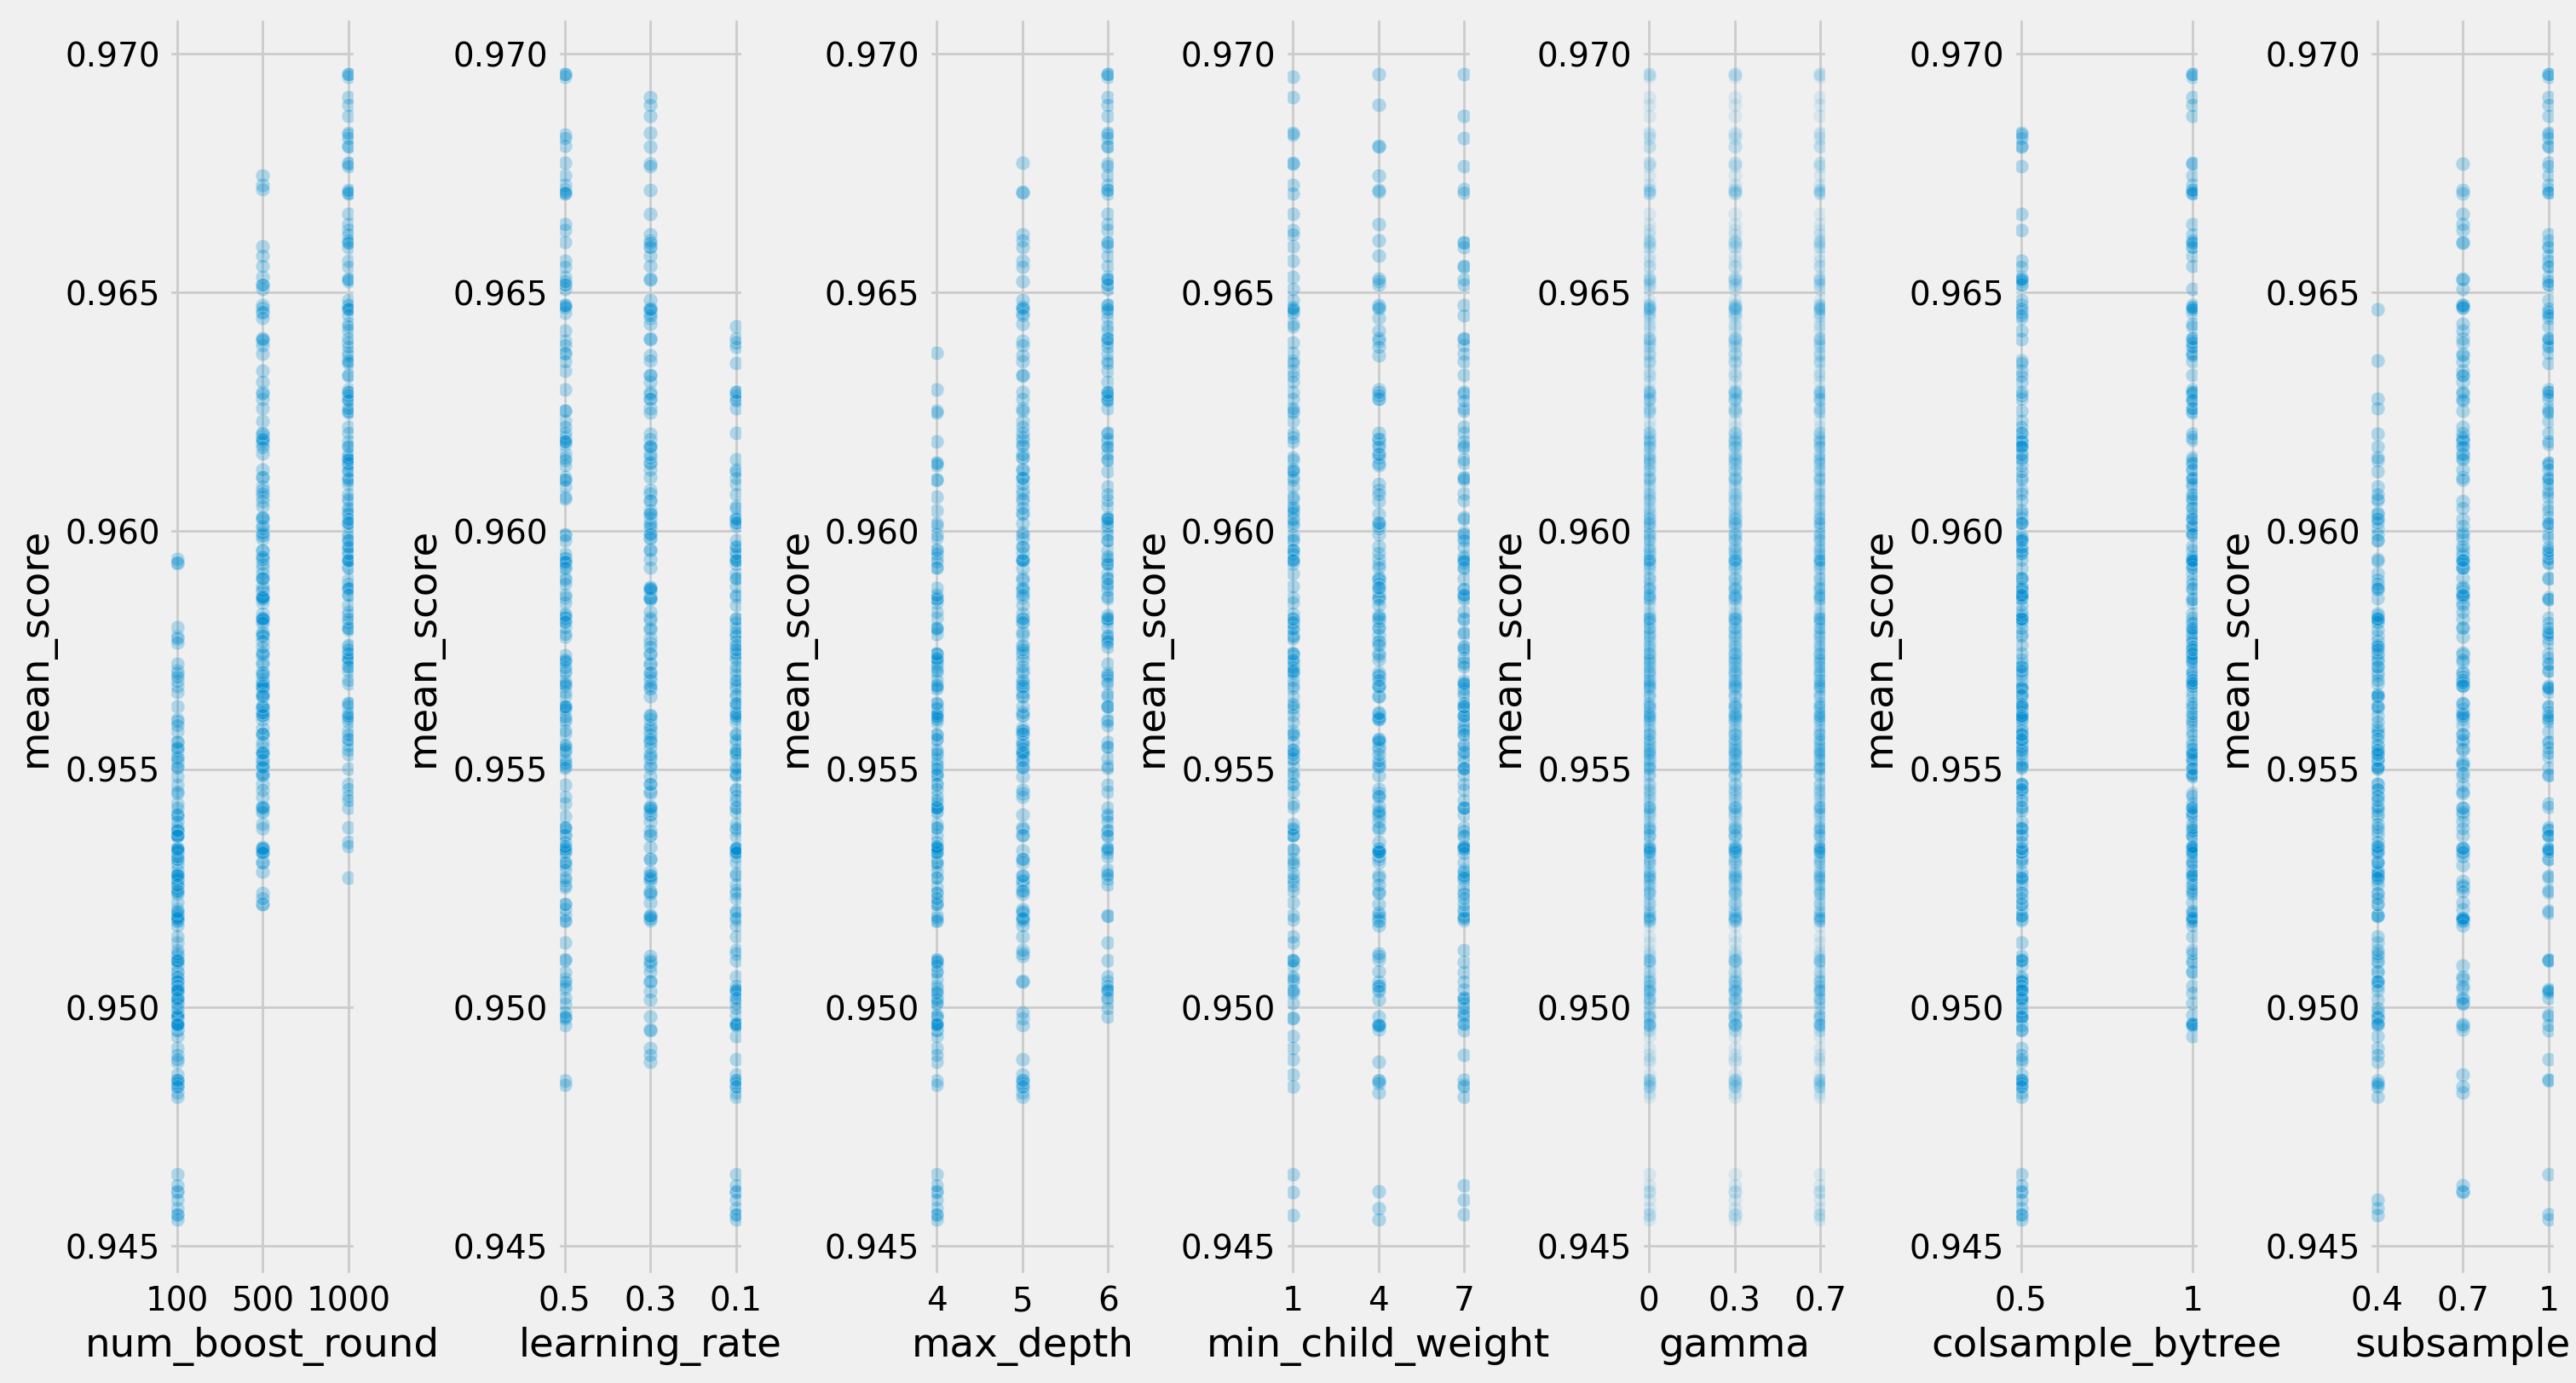

In [ ]:
n=len(df_param.columns)
fig,axes = plt.subplots(1,n,figsize=(15,8))
for key,ax in zip(df_param.columns,axes):
  sns.scatterplot(data=data,x=key,y='mean_score',ax=ax,alpha=0.1)

In [ ]:
for a,b in product(df_param.columns,repeat=2):
  print(a,b)

num_boost_round num_boost_round
num_boost_round learning_rate
num_boost_round max_depth
num_boost_round min_child_weight
num_boost_round gamma
num_boost_round colsample_bytree
num_boost_round subsample
learning_rate num_boost_round
learning_rate learning_rate
learning_rate max_depth
learning_rate min_child_weight
learning_rate gamma
learning_rate colsample_bytree
learning_rate subsample
max_depth num_boost_round
max_depth learning_rate
max_depth max_depth
max_depth min_child_weight
max_depth gamma
max_depth colsample_bytree
max_depth subsample
min_child_weight num_boost_round
min_child_weight learning_rate
min_child_weight max_depth
min_child_weight min_child_weight
min_child_weight gamma
min_child_weight colsample_bytree
min_child_weight subsample
gamma num_boost_round
gamma learning_rate
gamma max_depth
gamma min_child_weight
gamma gamma
gamma colsample_bytree
gamma subsample
colsample_bytree num_boost_round
colsample_bytree learning_rate
colsample_bytree max_depth
colsample_bytree m

In [ ]:
data.num_boost_round.value_counts()

,count
num_boost_round,
100,486
500,486
1000,486


{'4': 0, '5': 1, '6': 2}

<ipython-input-142-e39f6dfda73f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp['coeff'] = data_temp[hue_col].map(val_dict)
<ipython-input-142-e39f6dfda73f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp['max_depth'] = data_temp['max_depth'].astype(float)+data_temp['coeff']*0.05


<Axes: xlabel='max_depth', ylabel='mean_score'>

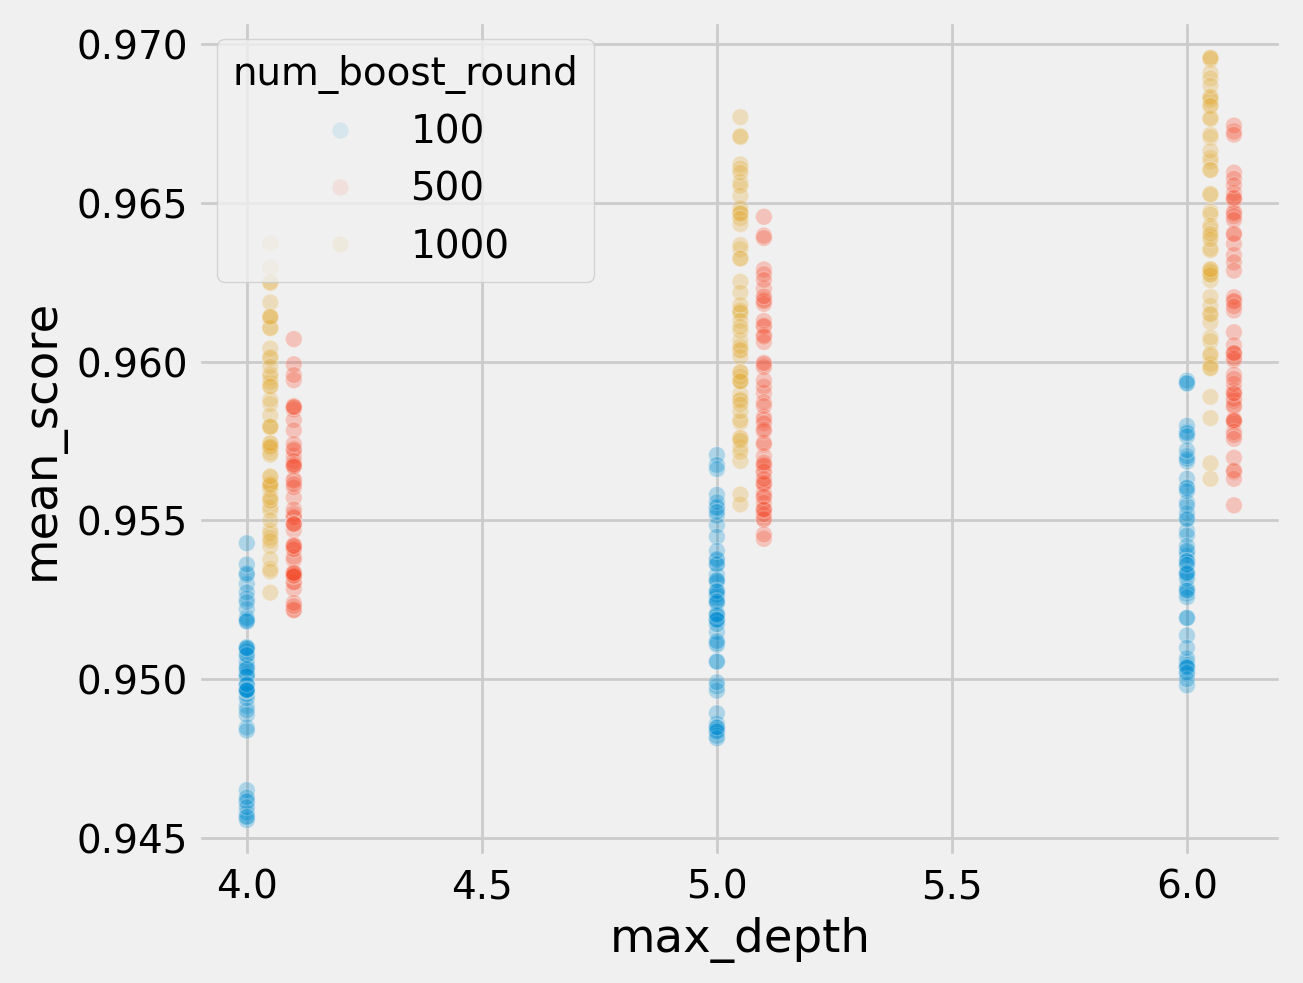

In [ ]:
fig,ax = plt.subplots()
hue_col = 'num_boost_round'
data_temp = data[['max_depth',hue_col,'mean_score']]
vals = data[hue_col].unique()
val_dict = { v : i for i,v in enumerate(np.sort(vals))}
data_temp['coeff'] = data_temp[hue_col].map(val_dict)
data_temp['max_depth'] = data_temp['max_depth'].astype(float)+data_temp['coeff']*0.05
sns.scatterplot(data=data_temp,x='max_depth',y='mean_score',hue='num_boost_round',ax=ax,alpha=0.1,legend='auto')

In [ ]:
type(data)

pandas.core.frame.DataFrame

In [173]:
def make_hue_df(data,col,hue_col,coeff=0.07):
  data_temp = data[[col,hue_col,'mean_score']].astype(float)
  vals = data_temp[hue_col].unique()
  val_dict = { v : i for i,v in enumerate(np.sort(vals))}
  data_temp['coeff'] = data_temp[hue_col].map(val_dict)
  data_temp[col] = data_temp[col]+data_temp['coeff']*coeff*(data_temp[col].std(ddof=0))
  return data_temp


In [181]:
from itertools import product

params=df_param.columns
n=len(params)
fig,axes = plt.subplots(3,n,figsize=(15,15))
for (key_fix,key2),ax in tqdm(zip(product(params[:3],params),axes.flatten())):
  if key_fix == key2 : continue
  data_temp = make_hue_df(data,key2,key_fix,0.15)
  sns.scatterplot(data=data_temp,x=key2,y='mean_score',hue=key_fix,ax=ax,alpha=0.2)
#axes.legend()
sns.set(font_scale=0.8)

Output hidden; open in https://colab.research.google.com to view.

In [182]:
from itertools import product

params=df_param.columns
n=len(params)
fig,axes = plt.subplots(n-3,n,figsize=(15,15))
for (key_fix,key2),ax in tqdm(zip(product(params[3:],params),axes.flatten())):
  if key_fix == key2 : continue
  data_temp = make_hue_df(data,key2,key_fix,0.15)
  sns.scatterplot(data=data_temp,x=key2,y='mean_score',hue=key_fix,ax=ax,alpha=0.2)
#axes.legend()
sns.set(font_scale=0.8)

Output hidden; open in https://colab.research.google.com to view.

In [189]:
data['mean_rmse'] = data[['rmse0','rmse1','rmse2']].apply(np.mean,axis=1)
data['std_rmse'] = data[['rmse0','rmse1','rmse2']].apply(np.std,axis=1)
data['std_score'] = data[['r2_score0','r2_score1','r2_score2']].apply(np.std,axis=1)

In [200]:
params

Index(['num_boost_round', 'learning_rate', 'max_depth', 'min_child_weight',
       'gamma', 'colsample_bytree', 'subsample'],
      dtype='object')

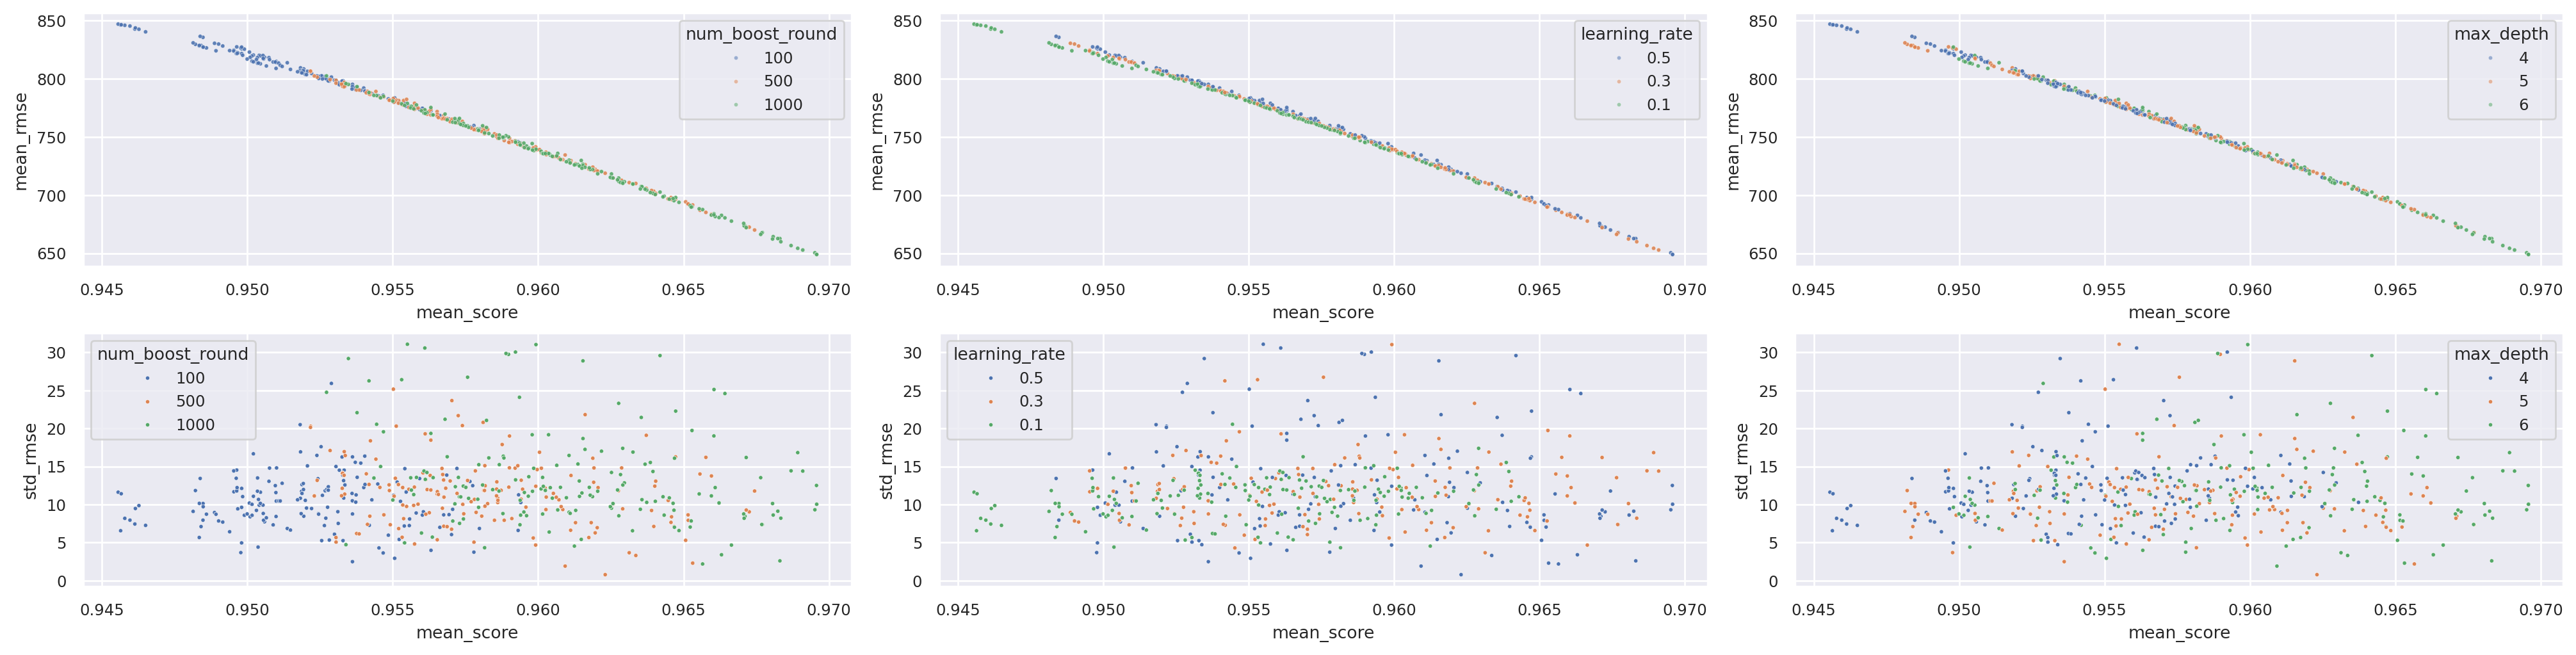

In [208]:
fig,ax = plt.subplots(2,3,figsize=(20,5))
for idx,hue_col in enumerate(params[:3]):
  sns.scatterplot(data,x='mean_score',y='mean_rmse',hue=hue_col,s=5,ax=ax[0][idx],alpha=0.5)
  sns.scatterplot(data,x='mean_score',y='std_rmse',hue=hue_col,s=5,ax=ax[1][idx])

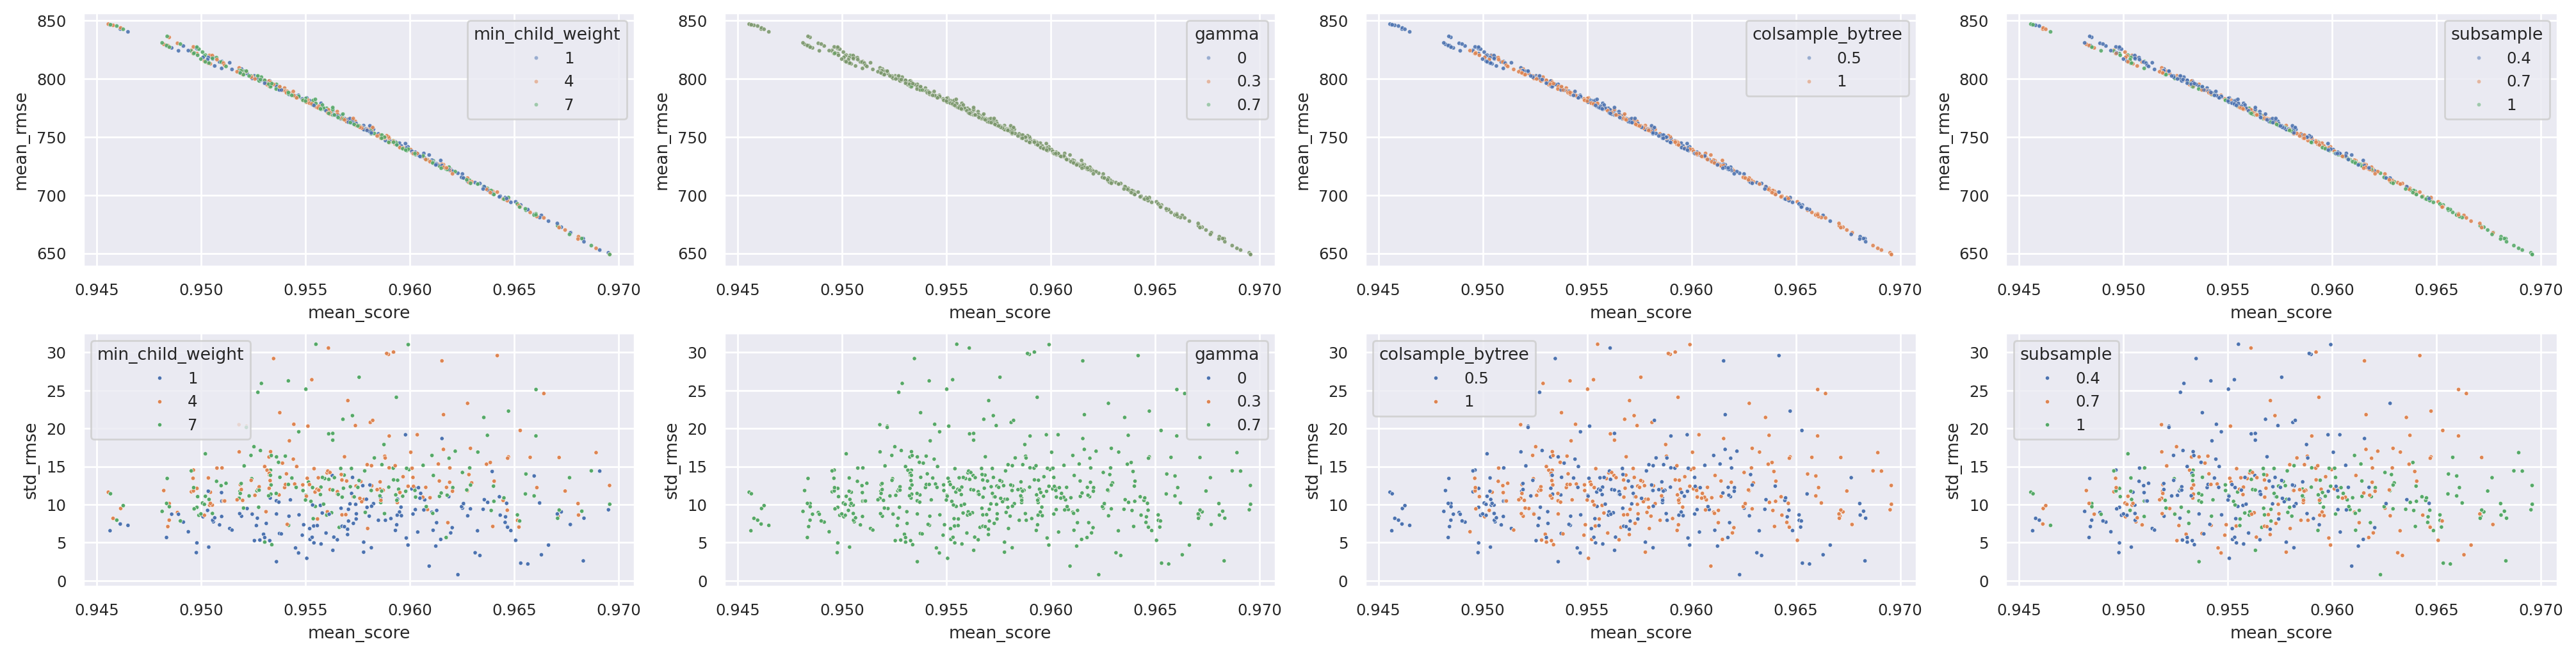

In [209]:
fig,ax = plt.subplots(2,4,figsize=(20,5))
for idx,hue_col in enumerate(params[3:]):
  sns.scatterplot(data,x='mean_score',y='mean_rmse',hue=hue_col,s=5,ax=ax[0][idx],alpha=0.5)
  sns.scatterplot(data,x='mean_score',y='std_rmse',hue=hue_col,s=5,ax=ax[1][idx])

In [211]:
rslt = []
for a,b,c in product(range(3),repeat=3):
  val = 15*a+10*b+6*c
  print(val)
  rslt.append(val)
np.unique(np.array(rslt),return_counts=True)


0
6
12
10
16
22
20
26
32
15
21
27
25
31
37
35
41
47
30
36
42
40
46
52
50
56
62


(array([ 0,  6, 10, 12, 15, 16, 20, 21, 22, 25, 26, 27, 30, 31, 32, 35, 36,
        37, 40, 41, 42, 46, 47, 50, 52, 56, 62]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1]))

In [215]:
def df_3col_hueing(data,cols):
  return data[cols].apply(lambda x:f'{cols[0]}:{x[0]},{cols[1]}:{x[1]},{cols[2]}:{x[2]}',axis=1)

<ipython-input-215-3957cdf73738>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return data[cols].apply(lambda x:f'{cols[0]}:{x[0]},{cols[1]}:{x[1]},{cols[2]}:{x[2]}',axis=1)
<ipython-input-222-3d7be9f13f86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp['hue_col'] = df_3col_hueing(data,cols)


<Axes: xlabel='mean_rmse', ylabel='std_rmse'>

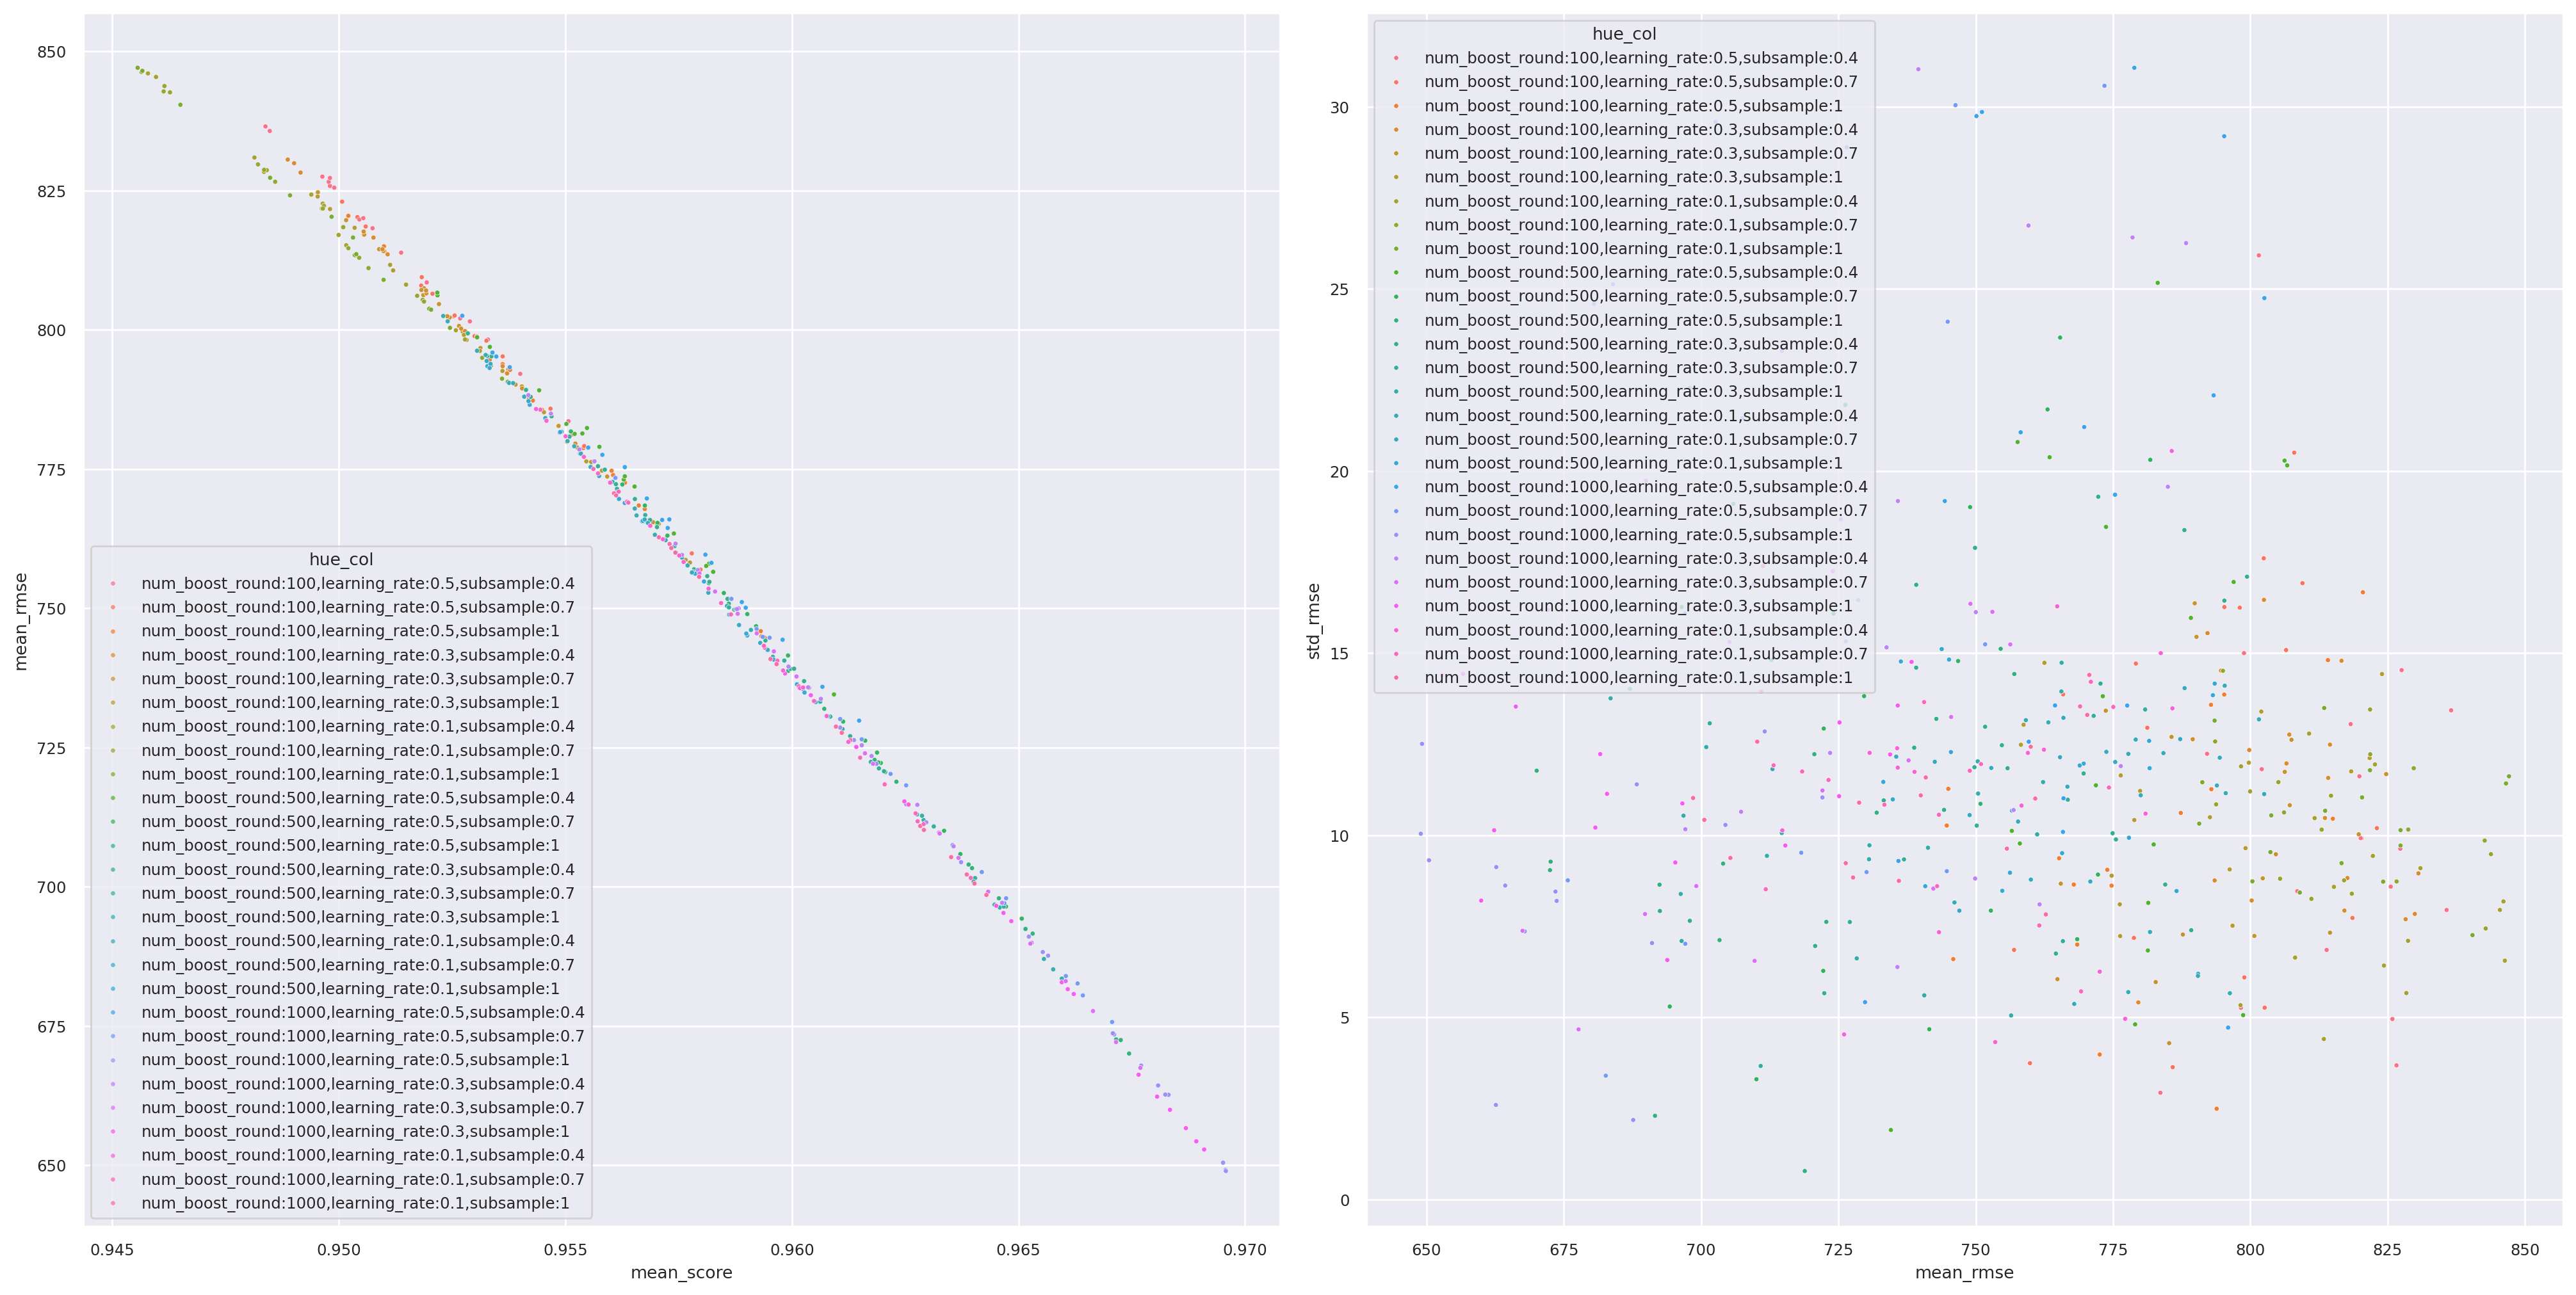

In [222]:
cols = ['num_boost_round','learning_rate','subsample']
data_temp = data[cols+['mean_score','mean_rmse','std_rmse']]
data_temp['hue_col'] = df_3col_hueing(data,cols)
fig,ax = plt.subplots(1,2,figsize=(20,10))
sns.scatterplot(data_temp,x='mean_score',y='mean_rmse',hue='hue_col',s=7,ax=ax[0],alpha=0.7)
sns.scatterplot(data_temp,x='mean_score',y='std_rmse',hue='hue_col',s=7,ax=ax[1])

In [ ]:
pd.DataFrame(df_score['rmse'].values.tolist()).add_prefix('rmse')

,rmse0,rmse1,rmse2
0,820.646888,824.406674,832.519236
1,809.784548,828.599761,817.365003
2,800.409645,820.342514,824.296419
3,797.793453,818.479974,809.337732
4,790.438360,804.572151,801.679145
...,...,...,...
1453,707.640740,735.170310,726.749567
1454,692.502355,720.373692,717.767338
1455,719.735730,748.002270,739.637099
1456,699.162773,728.300137,712.111529


In [ ]:
data.loc[1173]

,1173
score,"{'rmse': [751.2338515964566, 808.9114069573778..."
actual_rounds,"[995.0, 280.0, 201.0]"
mean_rounds,492
mean_score,0.954183
params,"[[num_boost_round, 1000], [learning_rate, 0.3]..."
rank_score,1007
std_rounds,357.133962
num_boost_round,1000
learning_rate,0.3
max_depth,4


# 세일즈 포인트 제외 - 그리드 서치 (old version)

In [ ]:
data_type = 'whole'
ver=1.0
strat= False
X_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_train.pkl'.format(data_type,ver,strat)))
X_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_val.pkl'.format(data_type,ver,strat)))
X_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_test.pkl'.format(data_type,ver,strat)))
y_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_train.pkl'.format(data_type,ver,strat)))
y_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_val.pkl'.format(data_type,ver,strat)))
y_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_test.pkl'.format(data_type,ver,strat)))

In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 68)

(125474, 68)

(156843, 68)

(501896,)

(125474,)

(156843,)

In [ ]:
h_params = {
    'n_estimators':[100,500,1000],
    'learning_rate':[1,0.5,0.3,0.1],
    'max_depth':[4,5,6],
    'min_child_weight' : [1,4,7],
    'gamma' : [0,0.3,0.7],
    'colsample_bytree':[0.3,0.5,1],
    'subsample' : [0.4,0.7,1],
#    'device':['cuda']
}

## XGB

**remove some col**
- -1 : SalesPoint
- -2 : RglrPrice

In [ ]:
#crop,crop_idx = False,[-1,-2]
#crop,crop_idx = True,[-2]
crop,crop_idx = True,[-1]
#crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : X_train.shape[1]+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        X_train = np.hstack([X_train[:,:i],X_train[:,i+1:]])
        X_val = np.hstack([X_val[:,:i],X_val[:,i+1:]])
        X_test = np.hstack([X_test[:,:i],X_test[:,i+1:]])

[67]


In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 67)

(125474, 67)

(156843, 67)

(501896,)

(125474,)

(156843,)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#xgbmodel = XGBRegressor(tree_method='gpu_hist', device='gpu:0')
xgbmodel = XGBRegressor(tree_method='hist', device='cuda:0')
GS_XGB = GridSearchCV(xgbmodel,param_grid=h_params,cv=3,n_jobs=-1,verbose=2)

In [ ]:
GS_XGB.fit(X_train,y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda:0',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=No...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 1],
                         'learning_rate': [1, 0.5, 0.3, 0.1],
                         'max_depth': [4, 5, 6],
                         'n_estimators': [100, 700, 2100]},
             verbose=2)

In [ ]:
display(GS_XGB.cv_results_['rank_test_score'])
great_idx = np.where(GS_XGB.cv_results_['rank_test_score']<15)
display(great_idx)
display(GS_XGB.cv_results_['mean_test_score'][great_idx])
display(GS_XGB.cv_results_['std_test_score'][great_idx])

array([105,  73,  49, 100,  61,  33,  98,  62,  48, 101,  60,  27,  93,
        38,  14,  83,  26,  10, 104,  70,  35,  96,  46,  16,  86,  28,
         3, 108,  88,  66, 107,  75,  36, 103,  51,  17,  97,  69,  44,
        94,  63,  45,  90,  64,  57,  91,  53,  22,  80,  32,  11,  72,
        20,   7,  95,  58,  29,  85,  34,   8,  77,  18,   2, 106,  79,
        54, 102,  67,  30,  89,  47,  13,  82,  59,  39,  78,  42,  31,
        71,  40,  41,  81,  43,  19,  68,  21,   6,  55,  12,   4,  87,
        52,  23,  76,  24,   5,  65,  15,   1,  99,  74,  50,  92,  56,
        25,  84,  37,   9], dtype=int32)

(array([ 14,  17,  26,  50,  53,  59,  62,  71,  86,  88,  89,  95,  98,
        107]),)

array([0.96226086, 0.96312638, 0.96455644, 0.96296922, 0.96358699,
       0.96321174, 0.96573546, 0.96231012, 0.9641249 , 0.96278151,
       0.96450174, 0.9643203 , 0.96580297, 0.96313973])

array([0.00294135, 0.00398097, 0.00353834, 0.00311702, 0.00397059,
       0.00367836, 0.00334638, 0.00382035, 0.00238201, 0.00316128,
       0.00307873, 0.0032346 , 0.00345094, 0.0031514 ])

In [ ]:
GS_XGB.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_colsample_bytree', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
best_idx = np.where(GS_XGB.cv_results_['rank_test_score']<7)
display(best_idx)
display(GS_XGB.cv_results_['mean_test_score'][best_idx])
display(GS_XGB.cv_results_['std_test_score'][best_idx])

(array([26, 62, 86, 89, 95, 98]),)

array([0.96455644, 0.96573546, 0.9641249 , 0.96450174, 0.9643203 ,
       0.96580297])

array([0.00353834, 0.00334638, 0.00238201, 0.00307873, 0.0032346 ,
       0.00345094])

In [ ]:
list(map(lambda x: GS_XGB.cv_results_['params'][x],best_idx[0]))

[{'colsample_bytree': 0.3,
  'learning_rate': 0.3,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 0.5,
  'learning_rate': 0.3,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'learning_rate': 0.5,
  'max_depth': 5,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'learning_rate': 0.5,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'learning_rate': 0.3,
  'max_depth': 5,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'learning_rate': 0.3,
  'max_depth': 6,
  'n_estimators': 2100}]

In [ ]:
best_idx = np.where(GS_XGB.cv_results_['rank_test_score']<3)
test_params0 = GS_XGB.cv_results_['params'][best_idx[0][0]]
test_params1 = GS_XGB.cv_results_['params'][best_idx[0][1]]

In [ ]:
display(test_params0)
display(test_params1)
display(GS_XGB.cv_results_['mean_test_score'][best_idx])
display(GS_XGB.cv_results_['std_test_score'][best_idx])

{'colsample_bytree': 0.5,
 'learning_rate': 0.3,
 'max_depth': 6,
 'n_estimators': 2100}

{'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'n_estimators': 2100}

array([0.96573546, 0.96580297])

array([0.00334638, 0.00345094])

In [ ]:
data_type = 'whole'
ver=1.0
strat= False
X_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_train.pkl'.format(data_type,ver,strat)))
X_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_val.pkl'.format(data_type,ver,strat)))
X_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_test.pkl'.format(data_type,ver,strat)))
y_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_train.pkl'.format(data_type,ver,strat)))
y_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_val.pkl'.format(data_type,ver,strat)))
y_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_test.pkl'.format(data_type,ver,strat)))

In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 68)

(125474, 68)

(156843, 68)

(501896,)

(125474,)

(156843,)

## XGB

**remove some col**
- -1 : SalesPoint
- -2 : RglrPrice

In [ ]:
#crop,crop_idx = False,[-1,-2]
#crop,crop_idx = True,[-2]
#crop,crop_idx = True,[-1]
crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : X_train.shape[1]+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        X_train = np.hstack([X_train[:,:i],X_train[:,i+1:]])
        X_val = np.hstack([X_val[:,:i],X_val[:,i+1:]])
        X_test = np.hstack([X_test[:,:i],X_test[:,i+1:]])

[67, 66]


In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 66)

(125474, 66)

(156843, 66)

(501896,)

(125474,)

(156843,)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
xgbmodel = XGBRegressor(tree_method='hist', device='cuda:0')
GS_XGB = GridSearchCV(xgbmodel,param_grid=h_params,cv=3,n_jobs=-1,verbose=2)

In [ ]:
GS_XGB.fit(X_train,y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda:0',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=No...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 1],
                         'learning_rate': [1, 0.5, 0.3, 0.1],
                         'max_depth': [4, 5, 6],
                         'n_estimators': [100, 700, 2100]},
             verbose=2)

In [ ]:
display(GS_XGB.cv_results_['rank_test_score'])
great_idx = np.where(GS_XGB.cv_results_['rank_test_score']<15)
display(great_idx)
display(GS_XGB.cv_results_['mean_test_score'][great_idx])
display(GS_XGB.cv_results_['std_test_score'][great_idx])

array([ 95,  63,  41,  83,  45,  19,  73,  28,  10,  96,  62,  40,  85,
        46,  17,  74,  26,   5, 102,  72,  49,  91,  52,  25,  80,  35,
         9, 108,  88,  68, 105,  76,  50, 100,  57,  31,  93,  56,  34,
        81,  39,  15,  66,  22,   7,  94,  58,  36,  82,  38,  12,  69,
        20,   3, 101,  67,  44,  89,  48,  18,  78,  27,   4, 107,  86,
        64, 104,  71,  47,  97,  54,  24,  90,  53,  29,  77,  32,  11,
        59,  16,   6,  92,  55,  30,  79,  33,   8,  65,  14,   1,  99,
        61,  37,  87,  43,  13,  75,  23,   2, 106,  84,  60, 103,  70,
        42,  98,  51,  21], dtype=int32)

(array([ 8, 17, 26, 44, 50, 53, 62, 77, 80, 86, 88, 89, 95, 98]),)

array([0.8782987 , 0.89164503, 0.88200398, 0.88339786, 0.87067531,
       0.89864328, 0.89279586, 0.87474704, 0.88675537, 0.88272901,
       0.86607776, 0.90480536, 0.86704928, 0.90136224])

array([0.00530382, 0.00382177, 0.0052687 , 0.00355226, 0.00407141,
       0.0059385 , 0.00551963, 0.00464835, 0.00417819, 0.00490018,
       0.00659555, 0.00602871, 0.00496302, 0.00586989])

In [ ]:
GS_XGB.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_colsample_bytree', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
best_idx = np.where(GS_XGB.cv_results_['rank_test_score']<7)
display(best_idx)
display(GS_XGB.cv_results_['mean_test_score'][best_idx])
display(GS_XGB.cv_results_['std_test_score'][best_idx])

(array([17, 53, 62, 80, 89, 98]),)

array([0.89164503, 0.89864328, 0.89279586, 0.88675537, 0.90480536,
       0.90136224])

array([0.00382177, 0.0059385 , 0.00551963, 0.00417819, 0.00602871,
       0.00586989])

In [ ]:
list(map(lambda x: GS_XGB.cv_results_['params'][x],best_idx[0]))

[{'colsample_bytree': 0.3,
  'learning_rate': 0.5,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 0.5,
  'learning_rate': 0.5,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 0.5,
  'learning_rate': 0.3,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'learning_rate': 1,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'learning_rate': 0.5,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'learning_rate': 0.3,
  'max_depth': 6,
  'n_estimators': 2100}]

In [ ]:
best_idx = np.where(GS_XGB.cv_results_['rank_test_score']<3)
test_params0 = GS_XGB.cv_results_['params'][best_idx[0][0]]
test_params1 = GS_XGB.cv_results_['params'][best_idx[0][1]]

In [ ]:
display(test_params0)
display(test_params1)
display(GS_XGB.cv_results_['mean_test_score'][best_idx])
display(GS_XGB.cv_results_['std_test_score'][best_idx])

{'colsample_bytree': 1,
 'learning_rate': 0.5,
 'max_depth': 6,
 'n_estimators': 2100}

{'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'n_estimators': 2100}

array([0.90480536, 0.90136224])

array([0.00602871, 0.00586989])

## 할인율 예측

In [ ]:
os.listdir(dir_path)

['whole.v1.0_st-False_X_test.pkl',
 'whole.v1.0_st-False_X_val.pkl',
 'whole.v1.0_st-False_y_val.pkl',
 'whole.v1.0_st-False_y_train.pkl',
 'whole.v1.0_st-False_y_test.pkl',
 'whole.v1.0_st-False_X_train.pkl',
 'whole.v1.0_st-False_y_discount_val.pkl',
 'whole.v1.0_st-False_y_discount_test.pkl',
 'whole.v1.0_st-False_y_discount_train.pkl']

In [ ]:
data_type = 'whole'
ver=1.0
strat= False
X_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_train.pkl'.format(data_type,ver,strat)))
X_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_val.pkl'.format(data_type,ver,strat)))
X_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_test.pkl'.format(data_type,ver,strat)))
y_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_discount_train.pkl'.format(data_type,ver,strat)))
y_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_discount_val.pkl'.format(data_type,ver,strat)))
y_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_discount_test.pkl'.format(data_type,ver,strat)))

In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 68)

(125474, 68)

(156843, 68)

(501896,)

(125474,)

(156843,)

## XGB

**remove some col**
- -1 : SalesPoint
- -2 : RglrPrice

In [ ]:
#crop,crop_idx = False,[-1,-2]
#crop,crop_idx = True,[-2]
#crop,crop_idx = True,[-1]
crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : X_train.shape[1]+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        X_train = np.hstack([X_train[:,:i],X_train[:,i+1:]])
        X_val = np.hstack([X_val[:,:i],X_val[:,i+1:]])
        X_test = np.hstack([X_test[:,:i],X_test[:,i+1:]])

[67, 66]


In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 66)

(125474, 66)

(156843, 66)

(501896,)

(125474,)

(156843,)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
xgbmodel = XGBRegressor(tree_method='hist', device='cuda:0')
GS_XGB = GridSearchCV(xgbmodel,param_grid=h_params,cv=3,n_jobs=-1,verbose=2)

In [ ]:
GS_XGB.fit(X_train,y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda:0',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=No...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 1],
                         'learning_rate': [1, 0.5, 0.3, 0.1],
                         'max_depth': [4, 5, 6],
                         'n_estimators': [100, 700, 2100]},
             verbose=2)

In [ ]:
display(GS_XGB.cv_results_['rank_test_score'])
great_idx = np.where(GS_XGB.cv_results_['rank_test_score']<15)
display(great_idx)
display(GS_XGB.cv_results_['mean_test_score'][great_idx])
display(GS_XGB.cv_results_['std_test_score'][great_idx])

array([ 95,  61,  40,  88,  49,  21,  79,  34,  19,  96,  62,  39,  86,
        46,  11,  75,  22,   5, 102,  69,  47,  92,  52,  16,  80,  33,
         6, 108,  87,  67, 105,  74,  50, 101,  57,  25,  93,  58,  35,
        83,  44,  20,  73,  29,  26,  94,  56,  30,  81,  38,   8,  71,
        14,   3, 100,  64,  42,  89,  48,  12,  76,  23,   2, 107,  84,
        63, 104,  70,  45,  99,  55,  17,  91,  53,  28,  77,  37,  18,
        66,  27,  32,  90,  54,  24,  78,  31,   7,  65,  10,   4,  97,
        60,  36,  85,  43,   9,  72,  15,   1, 106,  82,  59, 103,  68,
        41,  98,  51,  13], dtype=int32)

(array([ 14,  17,  26,  50,  52,  53,  59,  62,  86,  88,  89,  95,  98,
        107]),)

array([0.80996342, 0.82329849, 0.82223071, 0.81483305, 0.80627437,
       0.8245349 , 0.8086368 , 0.82617702, 0.81687052, 0.81157927,
       0.82390682, 0.81265653, 0.82772776, 0.80740232])

array([0.00206074, 0.00145055, 0.00198803, 0.00227827, 0.00218787,
       0.00222616, 0.00193066, 0.00209722, 0.00178781, 0.00204688,
       0.0019639 , 0.00225015, 0.00218021, 0.00183492])

In [ ]:
GS_XGB.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_colsample_bytree', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
best_idx = np.where(GS_XGB.cv_results_['rank_test_score']<7)
display(best_idx)
display(GS_XGB.cv_results_['mean_test_score'][best_idx])
display(GS_XGB.cv_results_['std_test_score'][best_idx])

(array([17, 26, 53, 62, 89, 98]),)

array([0.82329849, 0.82223071, 0.8245349 , 0.82617702, 0.82390682,
       0.82772776])

array([0.00145055, 0.00198803, 0.00222616, 0.00209722, 0.0019639 ,
       0.00218021])

In [ ]:
list(map(lambda x: GS_XGB.cv_results_['params'][x],best_idx[0]))

[{'colsample_bytree': 0.3,
  'learning_rate': 0.5,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 0.3,
  'learning_rate': 0.3,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 0.5,
  'learning_rate': 0.5,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 0.5,
  'learning_rate': 0.3,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'learning_rate': 0.5,
  'max_depth': 6,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'learning_rate': 0.3,
  'max_depth': 6,
  'n_estimators': 2100}]

In [ ]:
best_idx = np.where(GS_XGB.cv_results_['rank_test_score']<3)
test_params0 = GS_XGB.cv_results_['params'][best_idx[0][0]]
test_params1 = GS_XGB.cv_results_['params'][best_idx[0][1]]

In [ ]:
display(test_params0)
display(test_params1)
display(GS_XGB.cv_results_['mean_test_score'][best_idx])
display(GS_XGB.cv_results_['std_test_score'][best_idx])

{'colsample_bytree': 0.5,
 'learning_rate': 0.3,
 'max_depth': 6,
 'n_estimators': 2100}

{'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'n_estimators': 2100}

array([0.82617702, 0.82772776])

array([0.00209722, 0.00218021])

In [ ]:
xgbmodel_default = XGBRegressor(tree_method='hist', device='cuda:0')

In [ ]:
xgbmodel_default.set_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': 'cuda:0',
 'eval_metric': None,
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
xgbmodel_default.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': 'cuda:0',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
xgbmodel_default.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda:0', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgbmodel_default.subsample.__dir__()

['__new__',
 '__repr__',
 '__bool__',
 '__doc__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__init__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']